--------------
# Playbook 8 : Capsule Network Performance
--------------
Evaluate Capsule Network performance on various fractions of the malaria dataset colour images.

In [1]:
# Like a great many other libraries in Python, Keras is a mess of incompatability. 
# Need to use 2.2.4 or it breaks the CapsNet Code. I therefore standardise on 
# keras and tensorflow versions
!pip install gast==0.3.2
!pip install keras==2.2.4
!pip install tensorflow==1.15.2

Processing /root/.cache/pip/wheels/59/38/c6/234dc39b4f6951a0768fbc02d5b7207137a5b1d9094f0d54bf/gast-0.3.2-cp36-none-any.whl
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.2 which is incompatible.
ERROR: tensorflow-gpu 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.2 which is incompatible.
  Attempting uninstall: gast
    Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
Processing /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd/gast-0.2.2-cp36-none-any.whl
  Attempting uninstall: gast
    Found existing installation: gast 0.3.2
    Uninstalling gast-0.3.2:
      Successfully uninstalled gast-0.3.2


## 1. Bring zipped data file across from gdrive to extract locally within colab

In [2]:
#%env GPATH=/content/gdrive/My Drive/MSc AI/Project/msccode
%env GPATH=/tf/content/msccode

#from google.colab import drive
#drive.mount('/content/gdrive')
!cp "$GPATH/Datasets/processed-cell-images-malaria.zip" "processed-cell-images-malaria.zip"

env: GPATH=/tf/content/msccode


## 2. Remove existing dataset and extract dataset zip file

In [3]:
!rm -rf cell_images
!rm -rf dataset
!unzip -q 'processed-cell-images-malaria.zip'

## 3. Import required packages

In [4]:
import os
import shutil
import numpy as np
import cv2
import tensorflow as tf
import numpy as np
import keras as keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
import pickle
import sys

print(tf.__version__)
print(keras.__version__)

1.15.2
2.2.4


Using TensorFlow backend.


## 4. Define constants

In [5]:
IMG_SIZE = 44         # Data set images will be reframed to this width and height
TEST_FRACTION = 0.1   # Fraction of dataset to hold out for test purposes
VAL_SPLIT = 0.1       # Ammount of training data to use for validation
TEST_SPLIT = 0.1
BATCH_SIZE=32
EPOCHS=60

GPATH=os.environ['GPATH']

# Target image directory for 'processed' color images.
colorData = "./dataset/color/"
dstColorP = "./dataset/color/Parasitized/"
dstColorU = "./dataset/color/Uninfected/"

# Target image directory for 'processed' grayscale images.
grayData = "./dataset/gray/"
dstGrayP = "./dataset/gray/Parasitized/"
dstGrayU = "./dataset/gray/Uninfected/"

dataset_p_dirs=[dstColorP, dstGrayP]
dataset_u_dirs=[dstColorU, dstGrayU]

##5. Define function to load dataset into numpy arrays

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

def loadData(directory, labelMap, as_gray, quiet=True): 
    array_list = [] 
    label_list = []

    labels = [dn for dn in os.listdir(directory) if os.path.isdir(directory + '/' + dn)]

    for label in labels:
        classLabel = labelMap[label]
        subdir = directory + '/' + label
        files = [fn for fn in os.listdir(subdir) if fn.endswith(('.png'))] 
        print("Loading images for class {} from {}".format(classLabel, subdir))
        num_loaded = 0
        for img_file in files:
            file_path = subdir + '/' + img_file
            if as_gray is True:
                img = cv2.imread(file_path, 0)
            else:
                img = cv2.imread(file_path)
            img = img.astype('float32')
            array_list.append(img)
            label_list.append(classLabel)
            num_loaded += 1
            if not quiet:
                if num_loaded % 1000 == 0:
                    print("Loaded %d (of %d)..." %(num_loaded, len(files)))
        print("Completed loading %d (of %d) images" %(num_loaded, len(files)))
        print("")
        
    data = np.array(array_list)
    data /= 255.0
    return data, np.array(label_list)

def load_and_split_data(labelMap={"Uninfected": 0, "Parasitized":1},
                        gray=False, 
                        val_split=VAL_SPLIT, 
                        test_split=TEST_SPLIT):
    print("load_and_split_data called with Val/Test split fraction {}/{}".format(val_split, 
                                                                                 test_split))

    if gray: 
        data_X, data_Y  = loadData(grayData, labelMap, as_gray=True)
    else:
        data_X, data_Y  = loadData(colorData, labelMap, as_gray=False)
    idx = np.random.permutation(len(data_X))
    data_X, data_Y = data_X[idx], data_Y[idx]

    val_X = None; val_Y=None
    test_X = None; test_Y=None
    train_X = data_X; train_y = data_Y

    if test_split > 0:
        train_X, test_X, train_Y, test_Y = train_test_split(data_X, 
                                                            data_Y, 
                                                            test_size=test_split, 
                                                            stratify=data_Y)
    if val_split > 0:
        train_X, val_X, train_Y, val_Y = train_test_split(train_X, 
                                                          train_Y, 
                                                          test_size=val_split, 
                                                          stratify=train_Y)
    if gray:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
    else:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')  

    print("Training data set size is", train_X.shape, train_Y.shape)
    if val_split > 0:
        print("Validation data set size is",val_X.shape, val_Y.shape)
    if test_split > 0:
        print("Test data data set size is",test_X.shape, test_Y.shape)

    labels, counts = np.unique(train_Y, return_counts=True)
    print("Training data labels and counts are", labels, counts)
    if val_split > 0:
        labels, counts = np.unique(val_Y, return_counts=True)
        print("Validation data labels and counts are", labels, counts)
    if test_split > 0:
        labels, counts = np.unique(test_Y, return_counts=True)
        print("Test data labels and counts are", labels, counts)

    return (train_X, train_Y, val_X, val_Y, test_X, test_Y)

def k_fold_load_and_split(gray, splits=10, data_frac=1, test_split=TEST_SPLIT):
    print("k_fold_load_and_split called for {}% data fraction".format(data_frac * 100))
    print("Test split {}%. Number of folds {}".format(test_split * 100,
                                                       splits))

    data_X, data_Y, _, _, test_X, test_Y = load_and_split_data(gray=gray, 
                                                               val_split=0,
                                                               test_split = test_split)

    # Take the required fraction of available training data. 
    if data_frac < 1:
        train_size = int(data_frac * data_X.shape[0])
        test_size = int(data_frac * test_X.shape[0])
        print("Limiting training data to {}/{} samples".format(train_size,
                                                               test_size))
        data_X = data_X[0:train_size]
        data_Y = data_Y[0:train_size]
        test_X = test_X[0:test_size]
        test_Y = test_Y[0:test_size]

    skf = StratifiedKFold(n_splits=splits, shuffle=False) 
    folds = skf.split(data_X, data_Y) 

    return (data_X, data_Y, folds, test_X, test_Y)

##6. Define functions some utility functions for model performaance and accuracy

###6.1 Define function to plot model performance

In [7]:
import matplotlib.pyplot as plt
import math

def plotModelPerf(history, sup = None, file=None):
    # Plot model training and validation loss and accuracy on one graph
    # history is an object provided by a fit() operation on a model
    
    print("Plotting Model accuracy and loss versus epoch")

    length = len(history.history["loss"])
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(8,5))
    for key in history.history.keys():
        if 'caps' in key:
            plt.plot(np.arange(0, length), history.history[key], label=key)    
    if sup is None:
        plt.title("Training Loss and Accuracy", y = 1.05, fontsize=12)
    else:
        plt.title("Training Loss and Accuracy: ({})".format(sup), y = 1.05, fontsize=12)

    plt.xlabel("Epoch #") 
    plt.ylabel("Loss/Accuracy") 
    plt.legend()

    plt.tight_layout()
    plt.show()

    if file is not None:
        fig.savefig(file)

# Plot mis-classified images
def show_misclassified(test_Y, pred_Y, ground_truth, file=None):
    pos = 1
    rows = 8
    cols = 10
    fig = plt.figure(figsize=(1.5*cols,1.5*rows))  
    for index in range(len(test_Y)):
        # Look for images where the test label is not the same as predicted
        if test_Y[index] != results[index]:
            pixels = test_X[index]
            #pixels = pixels.reshape((44,44,3))
            label = test_Y[index]
            if label == ground_truth:
                f = fig.add_subplot(rows,cols,pos)
                pos+=1
                f.set_title("T=%d P=%d"% (label, results[index]))
                f.set_xticks([])
                f.set_yticks([])
                plt.imshow(pixels)
            if pos > rows * cols:
                break

    plt.tight_layout()
    plt.show()

    if file is not None:
        fig.savefig(file)

def showReconImages(in_imgs, out_imgs, shape, n=10, file = None):
    X, Y, CH = shape

    fig = plt.figure(figsize=(n*1.5, 2*1.5))

    for i in range(n):
        # display original
        f = fig.add_subplot(2, n, i+1)
        pixels = in_imgs[i].reshape(X, Y, CH)
        if len(shape) == 2 or shape[2] == 1:
            plt.imshow(pixels[:,:,0], cmap='gray') 
        else:
            plt.imshow(pixels[:,:,::-1]) # BGR -> RGB
        f.set_xticks([])
        f.set_yticks([])

        # display reconstruction
        f = fig.add_subplot(2, n, i+1 + n)
        pixels = out_imgs[i].reshape(X, Y, CH)
        if len(shape) == 2 or shape[2] == 1:
            plt.imshow(pixels[:,:,0], cmap='gray') 
        else:
            plt.imshow(pixels[:,:,::-1]) # BGR -> RGB
        f.set_xticks([])
        f.set_yticks([])
    
    plt.tight_layout()
    plt.show()

    if file is not None:
        fig.savefig(file)

###6.2 Define function to calculate model accuracy

In [8]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def getScores(model, test_X, test_Y):
    # Evaluate the model against the test data set.
    test_YC = keras.utils.np_utils.to_categorical(test_Y)

    results = model.evaluate([test_X, test_YC], [test_YC, test_X], verbose=0) 

    loss = results[0]
    accuracy = results[3]

    resultsProb = model.predict([test_X, test_YC], verbose=0) 
    results = np.argmax(resultsProb[0], axis=1) 

    precision = precision_score(test_Y, results, average='binary')
    recall = recall_score(test_Y, results, average='binary')
    f1 = f1_score(test_Y, results, average='binary')
    return (loss, accuracy, precision, recall, f1)

def showScores(scores):
    loss, accuracy, precision, recall, f1 = scores

    print("")
    print("Scores for classification model")   
    print("| %-8s | %-8s | %-9s | %-8s | %-8s"%
          ("Loss", "Accuracy", "Precision", "Recall", "F1"))
    print("| %-8s | %-8s | %-9s | %-8s | %-8s"%
          ('-' * 8, '-' * 8, '-' * 8, '-' * 8, '-' * 8)) 
    print("| %-8.3f | %-8.3f | %-9.3f | %-8.3f | %-8.3f"% 
          (loss, accuracy, precision, recall, f1))
      
def showModelScores(model, test_X, test_Y):
    scores = getScores(model, test_X, test_Y)
    showScores(scores)
    return scores

###6.3 Define wrapper function for model training

In [20]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
import random as rand

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rand.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/
session_conf = tf.ConfigProto(intra_op_parallelism_threads=4,
                              inter_op_parallelism_threads=4)
tf.set_random_seed(1234)

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
seed(11)
(train_X, train_Y, val_X, val_Y, test_X, test_Y) = load_and_split_data(gray=False)
train_YC = keras.utils.np_utils.to_categorical(train_Y)
val_YC = keras.utils.np_utils.to_categorical(val_Y)
test_YC = keras.utils.np_utils.to_categorical(test_Y)

def trainModel(bestFile, model, opt, trainX, trainY, valX, valY, batch, nepochs, 
               verbose=1, 
               es=True):  
    '''
    Define some early stopping conditions. The first one insists a model does better
    than ~51% by the end of one epoch otherwise don't bother. Experience with training
    indicates if a model does not do better than this at the end of one epoch it tends
    to just sit around 50% after each epoch and just does not make progress.
    '''
    cbs = []
    if es is True:
        patience = nepochs//3
        if patience < 10:
            patience = 10
        es1 = EarlyStopping(monitor='out_caps_acc', verbose=verbose, baseline=0.508, patience=2)
        es2 = EarlyStopping(monitor='out_caps_acc', mode='max', verbose=verbose, baseline=0.70, patience=patience)
        #es3 = EarlyStopping(monitor='out_caps_loss', mode='min', verbose=verbose, patience=patience)
        cbs = [es1, es2]

    if bestFile is not None:
        cbs.append(ModelCheckpoint(bestFile, 
                                   monitor='val_out_caps_loss', 
                                   mode='min', 
                                   save_best_only=True))

    model.compile(optimizer=opt,
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics=['accuracy'])

    history = model.fit([trainX, trainY], 
                        [trainY, trainX], 
                        batch_size=batch, 
                        epochs=nepochs,
                        callbacks=cbs,
                        validation_data=[[valX, valY], [valY, valX]],
                        verbose=verbose)
    return history
  
def CapsTest(k, 
             frac, 
             bs, 
             epochs, 
             f_sizes=[256,256], 
             p_dim=8, 
             d_dim=16,
             mshow = False, 
             es=True,
             plot = True,
             bestFile = None, 
             pltFile = None,
             sup=None,
             verbose=1):
    train_size = int(frac * train_X.shape[0]//100)
    val_size = int(frac * val_X.shape[0]//100)

    frac_train_X = train_X[0:train_size]
    frac_train_Y = train_Y[0:train_size]
    frac_train_YC = train_YC[0:train_size]
    frac_val_X = val_X[0:val_size]
    frac_val_Y = val_Y[0:val_size]
    frac_val_YC = val_YC[0:val_size]

    num_tries = 0
    try_again = True

    while try_again:
        K.clear_session()

        model = CapsNet(input_shape=frac_train_X.shape[1:],
                        n_class=2,
                        num_routing=3,
                        k_sizes=k,
                        f_sizes=f_sizes,
                        p_dim=p_dim,
                        d_dim=d_dim)

        if mshow and (num_tries == 0):
            model.summary()

        hist = trainModel(bestFile, 
                          model, 
                          keras.optimizers.Adam(lr=0.001),
                          frac_train_X, 
                          frac_train_YC,
                          frac_val_X, 
                          frac_val_YC,
                          bs,
                          epochs,
                          es=es,
                          verbose=verbose)
        
        num_tries += 1
        num_epochs = len(hist.history['val_out_caps_acc'])
        if num_epochs > 2:
            scores = hist.history['val_out_caps_acc']
            # Did we exceed treshold in any epoch
            for score in scores:
                if score*100 > 0.70:
                    try_again = False
                    break
            if try_again:
                # Model did'nt train to satisfaction (< tresh accuracy at end of training)
                # So try again.
                print("\tModel rejected. trying again")
                del model
                model = None
        elif num_tries == 10:
            # Failed to tain a model in 10 attempts so give up
            try_again = False
        else:
            del model
            model = None

    scores = getScores(model, test_X, test_Y)

    if plot:
        plotModelPerf(hist, sup=sup, file=pltFile)

    return (model, scores), hist

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Training data set size is (22321, 44, 44, 3) (22321,)
Validation data set size is (2481, 44, 44, 3) (2481,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [11161 11160]
Validation data labels and counts are [0 1] [1240 1241]
Test data labels and counts are [0 1] [1378 1378]


In [10]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

def cv_test(train_X, 
            train_Y, 
            folds, 
            test_X, 
            test_Y, 
            k, 
            f_sizes, 
            p_dim=8, 
            d_dim=16,
            bs=BATCH_SIZE, 
            nepochs=EPOCHS, 
            tresh=80):
    cvscores = []
    es1 = EarlyStopping(monitor='out_caps_acc', verbose=1, baseline=0.508, patience=nepochs//30)
    es2 = EarlyStopping(monitor='out_caps_acc', mode='max', verbose=1, baseline=0.70, patience=nepochs//3)
    #es3 = EarlyStopping(monitor='out_caps_loss', mode='min', verbose=1, patience=nepochs//6)

    train_YC = keras.utils.np_utils.to_categorical(train_Y)
    test_YC = keras.utils.np_utils.to_categorical(test_Y)

    iter = 0
    for train_index, test_index in folds:
        iter += 1
        print("Build and train on fold number {}".format(iter))
        mc = ModelCheckpoint('8_Best_CapsNet_CV_model_{}.h5'.format(iter), 
                              monitor='out_caps_loss', 
                              mode='min', 
                              save_best_only=True)
        
        model_accepted = False
        while model_accepted == False:
            model = CapsNet(input_shape=train_X.shape[1:],
                            n_class=2,
                            num_routing=3,
                            k_sizes=k,
                            f_sizes=f_sizes,
                            p_dim=p_dim,
                            d_dim=d_dim)
            
            model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
                          loss=[margin_loss, 'mse'],
                          loss_weights=[1., 0.0005],
                          metrics=['accuracy'])
      
            model.fit([train_X[train_index], train_YC[train_index]], 
                      [train_YC[train_index], train_X[train_index]], 
                      batch_size=bs, 
                      epochs=nepochs,
                      verbose=0,
                      callbacks=[es1,es2,mc])
    
            # evaluate the model
            scores = getScores(model, train_X[train_index], train_Y[train_index])

            print("\t%s: %.2f%% model score at end of training (with fold test data)" % ('accuracy', scores[1]*100))
            if scores[1]*100 > tresh:
                model_accepted = True 
                model.load_weights('8_Best_CapsNet_CV_model_{}.h5'.format(iter))
                scores = getScores(model, test_X, test_Y)
                print("\t%s: %.2f%% best model score on test set" % ('accuracy', scores[1]*100))
                cvscores.append(scores)
            else:
                print("\tModel rejected. trying again")
 
            K.clear_session()
            del model
            model = None
    return cvscores

##7 Define Capsule Network model functions
The following code is taken from 
* https://www.kaggle.com/kmader/capsulenet-on-mnist, 

This code, is in turn was based on the code by  Xifeng Guo at
* Author: Xifeng Guo, E-mail: guoxifeng1990@163.com, 
* Github: https://github.com/XifengGuo/CapsNet-Keras


In [11]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        """
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        def body(i, b, outputs):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]

        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        _, _, outputs = tf.while_loop(cond, body, loop_vars)
        """
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
            # tf.summary.histogram('BigBee', self.bias)  # for debugging
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

In [12]:
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical
K.set_image_data_format('channels_last')

def CapsNet(input_shape, n_class, num_routing, k_sizes=[9,9], f_sizes=[256,256], p_dim=8, d_dim=16):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    conv1 = layers.Conv2D(filters=f_sizes[0], kernel_size=k_sizes[0], strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=p_dim, n_channels=f_sizes[-1]//p_dim, kernel_size=k_sizes[-1], strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=d_dim, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(np.prod(input_shape), activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=input_shape, name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

##8. Build and run the CapsNet Model

###8.1 Define model parameters
These are low, but will actualy work quite well! They also reduce the training time. 

In [13]:
F_SIZE=[4,8]
K_SIZE=[5,11]
D_DIM=16

###8.2 Simple test with no Cross Validation

-------------------------------
Testing with filter sizes [4, 8]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 40, 4)    304         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 15, 15, 8)    3880        conv1[0][0]                      
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 225, 8)    

22321/22321 [==============================] - 31s 1ms/step - loss: 0.0316 - out_caps_loss: 0.0316 - out_recon_loss: 0.0327 - out_caps_acc: 0.9595 - out_recon_acc: 0.5078 - val_loss: 0.0454 - val_out_caps_loss: 0.0454 - val_out_recon_loss: 0.0333 - val_out_caps_acc: 0.9496 - val_out_recon_acc: 0.5040
Epoch 43/60
22321/22321 [==============================] - 31s 1ms/step - loss: 0.0306 - out_caps_loss: 0.0306 - out_recon_loss: 0.0325 - out_caps_acc: 0.9605 - out_recon_acc: 0.5082 - val_loss: 0.0458 - val_out_caps_loss: 0.0458 - val_out_recon_loss: 0.0332 - val_out_caps_acc: 0.9488 - val_out_recon_acc: 0.5049
Epoch 44/60
22321/22321 [==============================] - 32s 1ms/step - loss: 0.0304 - out_caps_loss: 0.0304 - out_recon_loss: 0.0324 - out_caps_acc: 0.9603 - out_recon_acc: 0.5088 - val_loss: 0.0452 - val_out_caps_loss: 0.0451 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.9484 - val_out_recon_acc: 0.5054
Epoch 45/60
22321/22321 [==============================] - 31s 1ms/ste

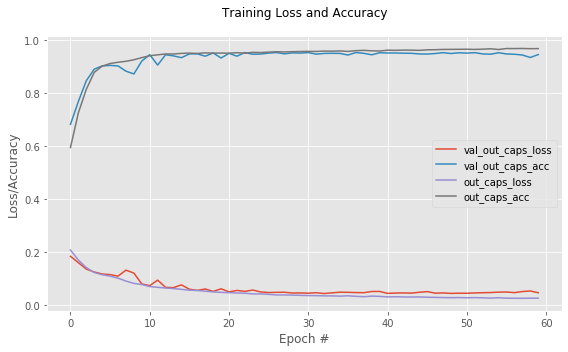


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.043    | 0.947    | 0.958     | 0.935    | 0.946   



In [0]:
print("-------------------------------")
print("Testing with filter sizes {}".format(F_SIZE))
print("Testing with Kernel sizes {}".format(K_SIZE))
print("Testing with d_dim size {}".format(D_DIM))
print("-------------------------------")
frac=100
(model, scores), hist = CapsTest(K_SIZE, 
                                frac=frac, 
                                bs=BATCH_SIZE, 
                                epochs=EPOCHS, 
                                plot=True, 
                                f_sizes=F_SIZE,
                                mshow=True,
                                es=False,
                                d_dim=D_DIM,
                                bestFile="8_FracTest{}.h5".format(frac),
                                pltFile="8_CapsnetModel_{}_frac{}_f{}.png".format(K_SIZE,
                                                                                   frac, 
                                                                                   F_SIZE))

print("")
print("Best model (min val loss) scores")
model.load_weights("8_FracTest{}.h5".format(frac))
showModelScores(model, test_X, test_Y)
print("") 
m100 = model

###8.3 Test with 10-fold Cross Validation

In [0]:
frac=100
(f_train_X, f_train_Y, folds, f_test_X, f_test_Y) = k_fold_load_and_split(gray=False, 
                                                                          splits=10, 
                                                                          data_frac=frac/100)
print("")
cvscores = cv_test(f_train_X, f_train_Y, folds, f_test_X, f_test_Y, 
                   k=K_SIZE, 
                   d_dim=D_DIM, 
                   f_sizes=F_SIZE, 
                   nepochs=EPOCHS*100//frac)
mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
print("")
print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))

k_fold_load_and_split called for 100.0% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]

Build and train on fold number 1
Epoch 00042: early stopping
	accuracy: 96.17% model score at end of training (with fold test data)
	accuracy: 94.45% best model score on test set
Build and train on fold number 2
Epoch 00016: early stopping
	accuracy: 94.36% model score at end of training (with fold test data)
	accuracy: 93.58% best model score on test set
Build and train on fold number 3
Epoch 00013: early stopping
	accura

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.00% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00011: early stopping
	accuracy: 93.17% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 5
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.00% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00031: early stopping
	accuracy: 94.49% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 6
Epoch 00036: early stopping
	accuracy: 95.74% model score at end of training (with fold test data)
	accuracy: 92.49% best model score on test set
Build and train on fold number 7
Epoch 00039: early stopping
	accuracy: 95.05% model score at end of training (with fold test data)
	accuracy: 91.84% best model score on test set
Build and train on fold number 8
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.00% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.00% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00019: early stopping
	accuracy: 94.25% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 9
Epoch 00046: early stopping
	accuracy: 96.95% model score at end of training (with fold test data)
	accuracy: 93.36% best model score on test set
Build and train on fold number 10
Epoch 00020: early stopping
	accuracy: 94.03% model score at end of training (with fold test data)
	accuracy: 93.25% best model score on test set

Cross validation mean loss on test data 0.057 (+/- 0.005)
Cross validation mean accuracy on test data 93.25% (+/- 0.79%)
Cross validation mean precision on test data 0.920 (+/- 0.014)
Cross validation mean recall on test data 0.948 (+/- 0.010)
Cross validation mean F1 on test data 0.934 (+/- 0.007)


##9. Model performance with different fractions of available training data

In [15]:
def fracTest(frac, k_size, f_size, d_dim, verbose=0, es=False):
    print("-------------------------------")
    print("Testing with filter sizes {}".format(f_size))
    print("Testing with Kernel sizes {}".format(k_size))
    print("Testing with d_dim size {}".format(d_dim))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=(EPOCHS * 100)//frac, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    es=es,
                                    verbose=verbose,
                                    d_dim=d_dim,
                                    sup= "{}% training data".format(frac),
                                    bestFile="8_FracTest{}.h5".format(frac),
                                    pltFile="8_CapsnetModel_{}_frac{}_f{}.png".format(k_size,
                                                                                       frac, 
                                                                                       f_size))
    print("")
    print("Best model (min val loss) scores")
    model.load_weights("8_FracTest{}.h5".format(frac))
    showModelScores(model, test_X, test_Y)
    print("") 
    return (model, scores)

-------------------------------
Testing with filter sizes [4, 8]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


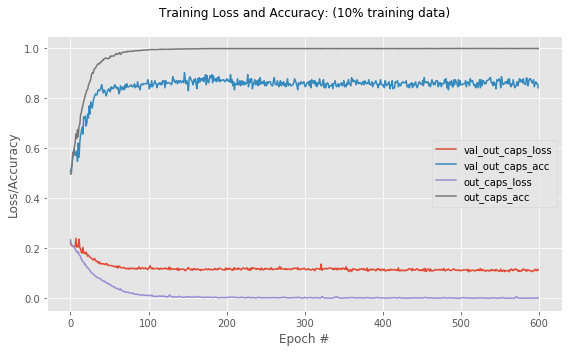


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.108    | 0.869    | 0.853     | 0.890    | 0.871   



(<keras.engine.training.Model at 0x7fc8214185f8>,
 (0.10892940373180221,
  0.8719158200290276,
  0.8700361010830325,
  0.874455732946299,
  0.8722403184943902))

In [0]:
fracTest(10, K_SIZE, F_SIZE, D_DIM)

-------------------------------
Testing with filter sizes [4, 8]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


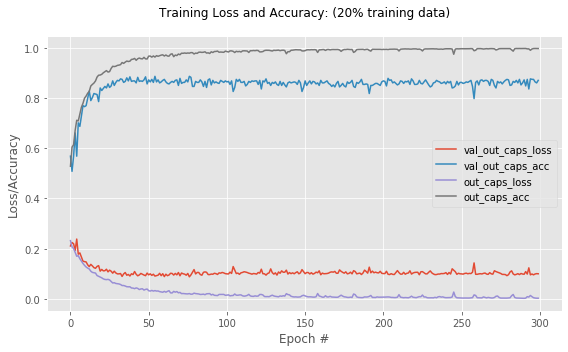


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.097    | 0.866    | 0.872     | 0.858    | 0.865   



(<keras.engine.training.Model at 0x7fc820684240>,
 (0.11211474755635628,
  0.8468795355587808,
  0.8519882179675994,
  0.839622641509434,
  0.8457602339181286))

In [0]:
fracTest(20, K_SIZE, F_SIZE, D_DIM)

-------------------------------
Testing with filter sizes [4, 8]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


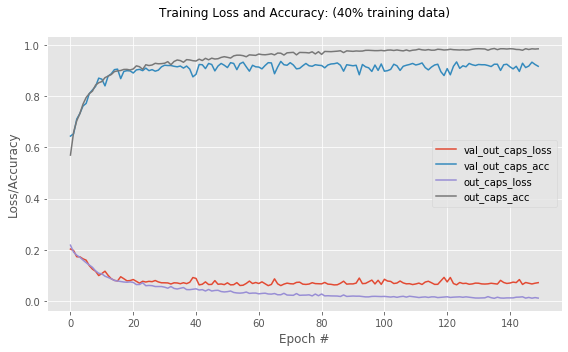


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.063    | 0.921    | 0.921     | 0.920    | 0.921   



(<keras.engine.training.Model at 0x7fc5fc462198>,
 (0.08079127470235488,
  0.897677793904209,
  0.8732970027247956,
  0.93033381712627,
  0.9009135628952916))

In [0]:
fracTest(40, K_SIZE, F_SIZE, D_DIM)

-------------------------------
Testing with filter sizes [4, 8]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


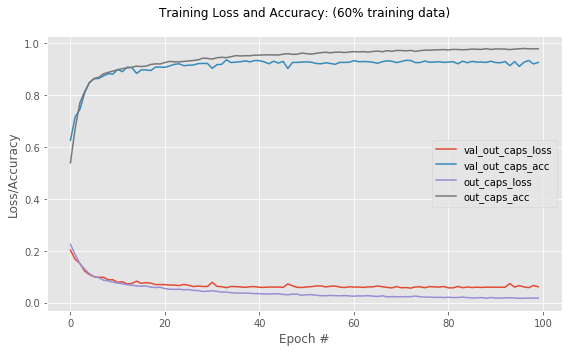


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.067    | 0.917    | 0.930     | 0.902    | 0.916   



(<keras.engine.training.Model at 0x7fc5e07b2f98>,
 (0.07141537491045621,
  0.9056603773584906,
  0.8909090909090909,
  0.9245283018867925,
  0.9074074074074073))

In [0]:
fracTest(60, K_SIZE, F_SIZE, D_DIM)

-------------------------------
Testing with filter sizes [4, 8]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


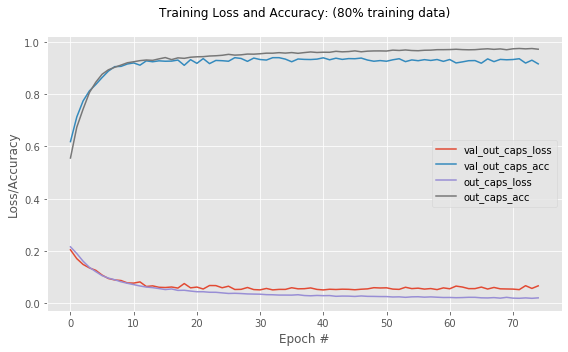


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.055    | 0.931    | 0.944     | 0.916    | 0.930   



(<keras.engine.training.Model at 0x7fc5e01d2c88>,
 (0.06309065824720592,
  0.9183599419448476,
  0.958631662688942,
  0.874455732946299,
  0.9146110056925997))

In [0]:
fracTest(80, K_SIZE, F_SIZE, D_DIM)

-------------------------------
Testing with filter sizes [8, 32]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------
Train on 8928 samples, validate on 992 samples
Epoch 1/150
8928/8928 [==============================] - 16s 2ms/step - loss: 0.2219 - out_caps_loss: 0.2219 - out_recon_loss: 0.0890 - out_caps_acc: 0.5952 - out_recon_acc: 0.3676 - val_loss: 0.1894 - val_out_caps_loss: 0.1894 - val_out_recon_loss: 0.0879 - val_out_caps_acc: 0.6512 - val_out_recon_acc: 0.3987
Epoch 2/150
8928/8928 [==============================] - 15s 2ms/step - loss: 0.1915 - out_caps_loss: 0.1915 - out_recon_loss: 0.0834 - out_caps_acc: 0.6630 - out_recon_acc: 0.4186 - val_loss: 0.1905 - val_out_caps_loss: 0.1904 - val_out_recon_loss: 0.0682 - val_out_caps_acc: 0.6663 - val_out_recon_acc: 0.4692
Epoch 3/150
8928/8928 [==============================] - 15s 2ms/step - loss: 0.1882 - out_caps_loss: 0.1882 - out_recon_loss: 0.0409 - out_caps_acc: 0.6729 - out_recon_a

8928/8928 [==============================] - 15s 2ms/step - loss: 0.0378 - out_caps_loss: 0.0378 - out_recon_loss: 0.0340 - out_caps_acc: 0.9708 - out_recon_acc: 0.5121 - val_loss: 0.0826 - val_out_caps_loss: 0.0825 - val_out_recon_loss: 0.0337 - val_out_caps_acc: 0.9083 - val_out_recon_acc: 0.5191
Epoch 27/150
8928/8928 [==============================] - 15s 2ms/step - loss: 0.0317 - out_caps_loss: 0.0317 - out_recon_loss: 0.0340 - out_caps_acc: 0.9757 - out_recon_acc: 0.5121 - val_loss: 0.0864 - val_out_caps_loss: 0.0864 - val_out_recon_loss: 0.0338 - val_out_caps_acc: 0.8992 - val_out_recon_acc: 0.5187
Epoch 28/150
8928/8928 [==============================] - 15s 2ms/step - loss: 0.0394 - out_caps_loss: 0.0394 - out_recon_loss: 0.0340 - out_caps_acc: 0.9673 - out_recon_acc: 0.5118 - val_loss: 0.0832 - val_out_caps_loss: 0.0832 - val_out_recon_loss: 0.0337 - val_out_caps_acc: 0.9052 - val_out_recon_acc: 0.5188
Epoch 29/150
8928/8928 [==============================] - 15s 2ms/step - l

8928/8928 [==============================] - 16s 2ms/step - loss: 0.0111 - out_caps_loss: 0.0111 - out_recon_loss: 0.0315 - out_caps_acc: 0.9922 - out_recon_acc: 0.5163 - val_loss: 0.0918 - val_out_caps_loss: 0.0918 - val_out_recon_loss: 0.0318 - val_out_caps_acc: 0.8861 - val_out_recon_acc: 0.5226
Epoch 53/150
8928/8928 [==============================] - 16s 2ms/step - loss: 0.0101 - out_caps_loss: 0.0100 - out_recon_loss: 0.0314 - out_caps_acc: 0.9942 - out_recon_acc: 0.5165 - val_loss: 0.0810 - val_out_caps_loss: 0.0810 - val_out_recon_loss: 0.0317 - val_out_caps_acc: 0.8901 - val_out_recon_acc: 0.5230
Epoch 54/150
8928/8928 [==============================] - 15s 2ms/step - loss: 0.0166 - out_caps_loss: 0.0166 - out_recon_loss: 0.0315 - out_caps_acc: 0.9867 - out_recon_acc: 0.5166 - val_loss: 0.0785 - val_out_caps_loss: 0.0785 - val_out_recon_loss: 0.0316 - val_out_caps_acc: 0.8921 - val_out_recon_acc: 0.5235
Epoch 55/150
8928/8928 [==============================] - 16s 2ms/step - l

8928/8928 [==============================] - 16s 2ms/step - loss: 0.0125 - out_caps_loss: 0.0125 - out_recon_loss: 0.0308 - out_caps_acc: 0.9917 - out_recon_acc: 0.5189 - val_loss: 0.0849 - val_out_caps_loss: 0.0849 - val_out_recon_loss: 0.0314 - val_out_caps_acc: 0.8861 - val_out_recon_acc: 0.5256
Epoch 79/150
8928/8928 [==============================] - 16s 2ms/step - loss: 0.0053 - out_caps_loss: 0.0053 - out_recon_loss: 0.0307 - out_caps_acc: 0.9978 - out_recon_acc: 0.5188 - val_loss: 0.0834 - val_out_caps_loss: 0.0834 - val_out_recon_loss: 0.0313 - val_out_caps_acc: 0.8911 - val_out_recon_acc: 0.5256
Epoch 80/150
8928/8928 [==============================] - 16s 2ms/step - loss: 0.0054 - out_caps_loss: 0.0054 - out_recon_loss: 0.0306 - out_caps_acc: 0.9971 - out_recon_acc: 0.5189 - val_loss: 0.0797 - val_out_caps_loss: 0.0796 - val_out_recon_loss: 0.0311 - val_out_caps_acc: 0.8911 - val_out_recon_acc: 0.5258
Epoch 81/150
8928/8928 [==============================] - 16s 2ms/step - l

8928/8928 [==============================] - 15s 2ms/step - loss: 0.0076 - out_caps_loss: 0.0076 - out_recon_loss: 0.0306 - out_caps_acc: 0.9963 - out_recon_acc: 0.5184 - val_loss: 0.0714 - val_out_caps_loss: 0.0714 - val_out_recon_loss: 0.0311 - val_out_caps_acc: 0.9052 - val_out_recon_acc: 0.5252
Epoch 105/150
8928/8928 [==============================] - 15s 2ms/step - loss: 0.0039 - out_caps_loss: 0.0038 - out_recon_loss: 0.0305 - out_caps_acc: 0.9984 - out_recon_acc: 0.5186 - val_loss: 0.0747 - val_out_caps_loss: 0.0746 - val_out_recon_loss: 0.0311 - val_out_caps_acc: 0.9022 - val_out_recon_acc: 0.5256
Epoch 106/150
8928/8928 [==============================] - 16s 2ms/step - loss: 0.0036 - out_caps_loss: 0.0035 - out_recon_loss: 0.0304 - out_caps_acc: 0.9984 - out_recon_acc: 0.5188 - val_loss: 0.0734 - val_out_caps_loss: 0.0734 - val_out_recon_loss: 0.0310 - val_out_caps_acc: 0.9012 - val_out_recon_acc: 0.5253
Epoch 107/150
8928/8928 [==============================] - 15s 2ms/step 

8928/8928 [==============================] - 15s 2ms/step - loss: 0.0030 - out_caps_loss: 0.0030 - out_recon_loss: 0.0303 - out_caps_acc: 0.9985 - out_recon_acc: 0.5196 - val_loss: 0.0762 - val_out_caps_loss: 0.0762 - val_out_recon_loss: 0.0309 - val_out_caps_acc: 0.8992 - val_out_recon_acc: 0.5260
Epoch 131/150
8928/8928 [==============================] - 15s 2ms/step - loss: 0.0024 - out_caps_loss: 0.0024 - out_recon_loss: 0.0303 - out_caps_acc: 0.9988 - out_recon_acc: 0.5195 - val_loss: 0.0716 - val_out_caps_loss: 0.0716 - val_out_recon_loss: 0.0309 - val_out_caps_acc: 0.9032 - val_out_recon_acc: 0.5259
Epoch 132/150
8928/8928 [==============================] - 16s 2ms/step - loss: 0.0085 - out_caps_loss: 0.0085 - out_recon_loss: 0.0304 - out_caps_acc: 0.9940 - out_recon_acc: 0.5194 - val_loss: 0.0953 - val_out_caps_loss: 0.0953 - val_out_recon_loss: 0.0312 - val_out_caps_acc: 0.8700 - val_out_recon_acc: 0.5258
Epoch 133/150
8928/8928 [==============================] - 15s 2ms/step 

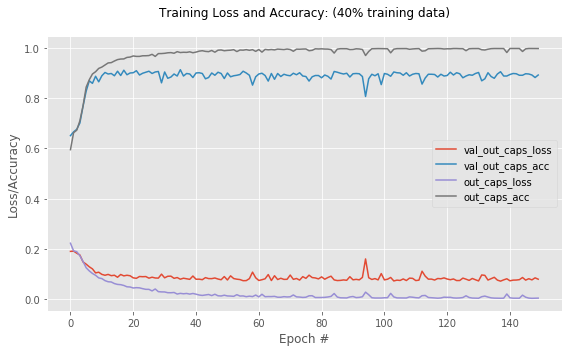


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.074    | 0.906    | 0.921     | 0.889    | 0.905   

-------------------------------
Testing with filter sizes [8, 32]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------
Train on 2232 samples, validate on 248 samples
Epoch 1/600
2232/2232 [==============================] - 5s 2ms/step - loss: 0.2501 - out_caps_loss: 0.2500 - out_recon_loss: 0.0892 - out_caps_acc: 0.4928 - out_recon_acc: 0.3318 - val_loss: 0.2162 - val_out_caps_loss: 0.2162 - val_out_recon_loss: 0.0891 - val_out_caps_acc: 0.5363 - val_out_recon_acc: 0.3406
Epoch 2/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.2143 - out_caps_loss: 0.2143 - out_recon_loss: 0.0889 - out_caps_acc: 0.5573 - out_recon_acc: 0.3457 - val_loss: 0.2146 - val_out_caps_loss: 0.2145 - val_out_recon_loss

Epoch 26/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0468 - out_caps_loss: 0.0468 - out_recon_loss: 0.0346 - out_caps_acc: 0.9700 - out_recon_acc: 0.5152 - val_loss: 0.1579 - val_out_caps_loss: 0.1579 - val_out_recon_loss: 0.0347 - val_out_caps_acc: 0.7379 - val_out_recon_acc: 0.5328
Epoch 27/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0449 - out_caps_loss: 0.0449 - out_recon_loss: 0.0346 - out_caps_acc: 0.9718 - out_recon_acc: 0.5144 - val_loss: 0.1620 - val_out_caps_loss: 0.1620 - val_out_recon_loss: 0.0347 - val_out_caps_acc: 0.7460 - val_out_recon_acc: 0.5320
Epoch 28/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0391 - out_caps_loss: 0.0391 - out_recon_loss: 0.0346 - out_caps_acc: 0.9803 - out_recon_acc: 0.5137 - val_loss: 0.1679 - val_out_caps_loss: 0.1679 - val_out_recon_loss: 0.0347 - val_out_caps_acc: 0.7298 - val_out_recon_acc: 0.5313
Epoch 29/600
2232/2232 [==============================] - 4s 2ms

2232/2232 [==============================] - 4s 2ms/step - loss: 0.0106 - out_caps_loss: 0.0106 - out_recon_loss: 0.0343 - out_caps_acc: 0.9964 - out_recon_acc: 0.5104 - val_loss: 0.1582 - val_out_caps_loss: 0.1582 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.7621 - val_out_recon_acc: 0.5277
Epoch 53/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0102 - out_caps_loss: 0.0102 - out_recon_loss: 0.0343 - out_caps_acc: 0.9964 - out_recon_acc: 0.5105 - val_loss: 0.1553 - val_out_caps_loss: 0.1553 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.7379 - val_out_recon_acc: 0.5280
Epoch 54/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0092 - out_caps_loss: 0.0092 - out_recon_loss: 0.0342 - out_caps_acc: 0.9969 - out_recon_acc: 0.5107 - val_loss: 0.1550 - val_out_caps_loss: 0.1550 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.7379 - val_out_recon_acc: 0.5280
Epoch 55/600
2232/2232 [==============================] - 4s 2ms/step - loss:

2232/2232 [==============================] - 4s 2ms/step - loss: 0.0051 - out_caps_loss: 0.0051 - out_recon_loss: 0.0340 - out_caps_acc: 0.9987 - out_recon_acc: 0.5113 - val_loss: 0.1574 - val_out_caps_loss: 0.1574 - val_out_recon_loss: 0.0343 - val_out_caps_acc: 0.7500 - val_out_recon_acc: 0.5286
Epoch 79/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0044 - out_caps_loss: 0.0044 - out_recon_loss: 0.0340 - out_caps_acc: 0.9978 - out_recon_acc: 0.5113 - val_loss: 0.1553 - val_out_caps_loss: 0.1553 - val_out_recon_loss: 0.0342 - val_out_caps_acc: 0.7419 - val_out_recon_acc: 0.5287
Epoch 80/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0047 - out_caps_loss: 0.0047 - out_recon_loss: 0.0340 - out_caps_acc: 0.9982 - out_recon_acc: 0.5110 - val_loss: 0.1574 - val_out_caps_loss: 0.1573 - val_out_recon_loss: 0.0342 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5285
Epoch 81/600
2232/2232 [==============================] - 4s 2ms/step - loss:

Epoch 104/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0072 - out_caps_loss: 0.0071 - out_recon_loss: 0.0336 - out_caps_acc: 0.9973 - out_recon_acc: 0.5102 - val_loss: 0.1645 - val_out_caps_loss: 0.1645 - val_out_recon_loss: 0.0338 - val_out_caps_acc: 0.7379 - val_out_recon_acc: 0.5281
Epoch 105/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0058 - out_caps_loss: 0.0058 - out_recon_loss: 0.0336 - out_caps_acc: 0.9991 - out_recon_acc: 0.5103 - val_loss: 0.1528 - val_out_caps_loss: 0.1528 - val_out_recon_loss: 0.0337 - val_out_caps_acc: 0.7702 - val_out_recon_acc: 0.5284
Epoch 106/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0042 - out_caps_loss: 0.0042 - out_recon_loss: 0.0335 - out_caps_acc: 0.9991 - out_recon_acc: 0.5103 - val_loss: 0.1719 - val_out_caps_loss: 0.1719 - val_out_recon_loss: 0.0338 - val_out_caps_acc: 0.7298 - val_out_recon_acc: 0.5285
Epoch 107/600
2232/2232 [==============================] - 4s

2232/2232 [==============================] - 4s 2ms/step - loss: 0.0032 - out_caps_loss: 0.0031 - out_recon_loss: 0.0328 - out_caps_acc: 0.9996 - out_recon_acc: 0.5122 - val_loss: 0.1735 - val_out_caps_loss: 0.1735 - val_out_recon_loss: 0.0331 - val_out_caps_acc: 0.7298 - val_out_recon_acc: 0.5303
Epoch 131/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0024 - out_caps_loss: 0.0023 - out_recon_loss: 0.0327 - out_caps_acc: 0.9996 - out_recon_acc: 0.5122 - val_loss: 0.1827 - val_out_caps_loss: 0.1827 - val_out_recon_loss: 0.0330 - val_out_caps_acc: 0.7056 - val_out_recon_acc: 0.5307
Epoch 132/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0179 - out_caps_loss: 0.0179 - out_recon_loss: 0.0327 - out_caps_acc: 0.9843 - out_recon_acc: 0.5123 - val_loss: 0.2404 - val_out_caps_loss: 0.2404 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.6371 - val_out_recon_acc: 0.5309
Epoch 133/600
2232/2232 [==============================] - 4s 2ms/step - lo

2232/2232 [==============================] - 4s 2ms/step - loss: 0.0017 - out_caps_loss: 0.0017 - out_recon_loss: 0.0320 - out_caps_acc: 0.9996 - out_recon_acc: 0.5126 - val_loss: 0.1747 - val_out_caps_loss: 0.1747 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7298 - val_out_recon_acc: 0.5313
Epoch 157/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0020 - out_caps_loss: 0.0020 - out_recon_loss: 0.0320 - out_caps_acc: 0.9996 - out_recon_acc: 0.5126 - val_loss: 0.1765 - val_out_caps_loss: 0.1764 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7298 - val_out_recon_acc: 0.5313
Epoch 158/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0024 - out_caps_loss: 0.0024 - out_recon_loss: 0.0319 - out_caps_acc: 0.9996 - out_recon_acc: 0.5125 - val_loss: 0.1717 - val_out_caps_loss: 0.1717 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5316
Epoch 159/600
2232/2232 [==============================] - 4s 2ms/step - lo

2232/2232 [==============================] - 4s 2ms/step - loss: 0.0015 - out_caps_loss: 0.0015 - out_recon_loss: 0.0314 - out_caps_acc: 1.0000 - out_recon_acc: 0.5126 - val_loss: 0.1725 - val_out_caps_loss: 0.1725 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7419 - val_out_recon_acc: 0.5320
Epoch 183/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0015 - out_caps_loss: 0.0015 - out_recon_loss: 0.0314 - out_caps_acc: 1.0000 - out_recon_acc: 0.5125 - val_loss: 0.1675 - val_out_caps_loss: 0.1675 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7500 - val_out_recon_acc: 0.5316
Epoch 184/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0012 - out_caps_loss: 0.0012 - out_recon_loss: 0.0314 - out_caps_acc: 1.0000 - out_recon_acc: 0.5123 - val_loss: 0.1740 - val_out_caps_loss: 0.1740 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7218 - val_out_recon_acc: 0.5318
Epoch 185/600
2232/2232 [==============================] - 4s 2ms/step - lo

Epoch 208/600
2232/2232 [==============================] - 4s 2ms/step - loss: 9.4646e-04 - out_caps_loss: 9.3092e-04 - out_recon_loss: 0.0311 - out_caps_acc: 1.0000 - out_recon_acc: 0.5131 - val_loss: 0.1800 - val_out_caps_loss: 0.1800 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5324
Epoch 209/600
2232/2232 [==============================] - 4s 2ms/step - loss: 9.8548e-04 - out_caps_loss: 9.6994e-04 - out_recon_loss: 0.0311 - out_caps_acc: 1.0000 - out_recon_acc: 0.5132 - val_loss: 0.1740 - val_out_caps_loss: 0.1740 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5327
Epoch 210/600
2232/2232 [==============================] - 4s 2ms/step - loss: 6.2158e-04 - out_caps_loss: 6.0606e-04 - out_recon_loss: 0.0310 - out_caps_acc: 1.0000 - out_recon_acc: 0.5133 - val_loss: 0.1729 - val_out_caps_loss: 0.1729 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7339 - val_out_recon_acc: 0.5327
Epoch 211/600
2232/2232 [============

2232/2232 [==============================] - 4s 2ms/step - loss: 0.0020 - out_caps_loss: 0.0020 - out_recon_loss: 0.0309 - out_caps_acc: 1.0000 - out_recon_acc: 0.5133 - val_loss: 0.1829 - val_out_caps_loss: 0.1829 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.7298 - val_out_recon_acc: 0.5331
Epoch 235/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0018 - out_caps_loss: 0.0018 - out_recon_loss: 0.0309 - out_caps_acc: 1.0000 - out_recon_acc: 0.5134 - val_loss: 0.1650 - val_out_caps_loss: 0.1650 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.7419 - val_out_recon_acc: 0.5327
Epoch 236/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0016 - out_caps_loss: 0.0016 - out_recon_loss: 0.0309 - out_caps_acc: 1.0000 - out_recon_acc: 0.5132 - val_loss: 0.1809 - val_out_caps_loss: 0.1808 - val_out_recon_loss: 0.0332 - val_out_caps_acc: 0.7298 - val_out_recon_acc: 0.5330
Epoch 237/600
2232/2232 [==============================] - 4s 2ms/step - lo

Epoch 260/600
2232/2232 [==============================] - 4s 2ms/step - loss: 4.2046e-04 - out_caps_loss: 4.0508e-04 - out_recon_loss: 0.0308 - out_caps_acc: 1.0000 - out_recon_acc: 0.5143 - val_loss: 0.1723 - val_out_caps_loss: 0.1722 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7581 - val_out_recon_acc: 0.5334
Epoch 261/600
2232/2232 [==============================] - 4s 2ms/step - loss: 8.3046e-04 - out_caps_loss: 8.1508e-04 - out_recon_loss: 0.0308 - out_caps_acc: 1.0000 - out_recon_acc: 0.5144 - val_loss: 0.1692 - val_out_caps_loss: 0.1692 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7581 - val_out_recon_acc: 0.5331
Epoch 262/600
2232/2232 [==============================] - 4s 2ms/step - loss: 8.4700e-04 - out_caps_loss: 8.3162e-04 - out_recon_loss: 0.0307 - out_caps_acc: 1.0000 - out_recon_acc: 0.5142 - val_loss: 0.1800 - val_out_caps_loss: 0.1800 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7298 - val_out_recon_acc: 0.5337
Epoch 263/600
2232/2232 [============

Epoch 286/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0015 - out_caps_loss: 0.0015 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5145 - val_loss: 0.1615 - val_out_caps_loss: 0.1615 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7661 - val_out_recon_acc: 0.5333
Epoch 287/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0015 - out_caps_loss: 0.0015 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5143 - val_loss: 0.1725 - val_out_caps_loss: 0.1724 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7500 - val_out_recon_acc: 0.5328
Epoch 288/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0034 - out_caps_loss: 0.0034 - out_recon_loss: 0.0307 - out_caps_acc: 1.0000 - out_recon_acc: 0.5143 - val_loss: 0.1751 - val_out_caps_loss: 0.1751 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.7460 - val_out_recon_acc: 0.5331
Epoch 289/600
2232/2232 [==============================] - 4s

Epoch 312/600
2232/2232 [==============================] - 4s 2ms/step - loss: 2.7495e-05 - out_caps_loss: 1.2208e-05 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5149 - val_loss: 0.1724 - val_out_caps_loss: 0.1724 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7460 - val_out_recon_acc: 0.5338
Epoch 313/600
2232/2232 [==============================] - 4s 2ms/step - loss: 2.2062e-05 - out_caps_loss: 6.7815e-06 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5148 - val_loss: 0.1725 - val_out_caps_loss: 0.1725 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7460 - val_out_recon_acc: 0.5338
Epoch 314/600
2232/2232 [==============================] - 4s 2ms/step - loss: 2.0239e-05 - out_caps_loss: 4.9616e-06 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5149 - val_loss: 0.1719 - val_out_caps_loss: 0.1718 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7500 - val_out_recon_acc: 0.5338
Epoch 315/600
2232/2232 [============

2232/2232 [==============================] - 4s 2ms/step - loss: 1.5586e-05 - out_caps_loss: 3.4095e-07 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5151 - val_loss: 0.1710 - val_out_caps_loss: 0.1710 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7540 - val_out_recon_acc: 0.5338
Epoch 338/600
2232/2232 [==============================] - 4s 2ms/step - loss: 1.5550e-05 - out_caps_loss: 3.0515e-07 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5151 - val_loss: 0.1710 - val_out_caps_loss: 0.1710 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.7540 - val_out_recon_acc: 0.5337
Epoch 339/600
2232/2232 [==============================] - 4s 2ms/step - loss: 1.5514e-05 - out_caps_loss: 2.7569e-07 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5150 - val_loss: 0.1710 - val_out_caps_loss: 0.1710 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.7540 - val_out_recon_acc: 0.5339
Epoch 340/600
2232/2232 [==========================

2232/2232 [==============================] - 4s 2ms/step - loss: 1.5241e-05 - out_caps_loss: 4.9530e-08 - out_recon_loss: 0.0304 - out_caps_acc: 1.0000 - out_recon_acc: 0.5152 - val_loss: 0.1710 - val_out_caps_loss: 0.1710 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.7500 - val_out_recon_acc: 0.5340
Epoch 363/600
2232/2232 [==============================] - 4s 2ms/step - loss: 1.5233e-05 - out_caps_loss: 4.0714e-08 - out_recon_loss: 0.0304 - out_caps_acc: 1.0000 - out_recon_acc: 0.5152 - val_loss: 0.1709 - val_out_caps_loss: 0.1709 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.7500 - val_out_recon_acc: 0.5340
Epoch 364/600
2232/2232 [==============================] - 4s 2ms/step - loss: 1.5225e-05 - out_caps_loss: 3.9251e-08 - out_recon_loss: 0.0304 - out_caps_acc: 1.0000 - out_recon_acc: 0.5152 - val_loss: 0.1710 - val_out_caps_loss: 0.1710 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.7500 - val_out_recon_acc: 0.5339
Epoch 365/600
2232/2232 [==========================

Epoch 388/600
2232/2232 [==============================] - 4s 2ms/step - loss: 9.9099e-04 - out_caps_loss: 9.7572e-04 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5152 - val_loss: 0.1625 - val_out_caps_loss: 0.1625 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.7661 - val_out_recon_acc: 0.5334
Epoch 389/600
2232/2232 [==============================] - 4s 2ms/step - loss: 7.7163e-04 - out_caps_loss: 7.5638e-04 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5153 - val_loss: 0.1574 - val_out_caps_loss: 0.1574 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7823 - val_out_recon_acc: 0.5332
Epoch 390/600
2232/2232 [==============================] - 4s 2ms/step - loss: 9.8738e-04 - out_caps_loss: 9.7213e-04 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5152 - val_loss: 0.1624 - val_out_caps_loss: 0.1624 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7621 - val_out_recon_acc: 0.5336
Epoch 391/600
2232/2232 [============

Epoch 414/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0024 - out_caps_loss: 0.0024 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5152 - val_loss: 0.1531 - val_out_caps_loss: 0.1531 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7903 - val_out_recon_acc: 0.5333
Epoch 415/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0022 - out_caps_loss: 0.0021 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5154 - val_loss: 0.1462 - val_out_caps_loss: 0.1462 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.7782 - val_out_recon_acc: 0.5330
Epoch 416/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0022 - out_caps_loss: 0.0022 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5152 - val_loss: 0.1637 - val_out_caps_loss: 0.1637 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7702 - val_out_recon_acc: 0.5332
Epoch 417/600
2232/2232 [==============================] - 4s

2232/2232 [==============================] - 4s 2ms/step - loss: 0.0021 - out_caps_loss: 0.0021 - out_recon_loss: 0.0304 - out_caps_acc: 0.9973 - out_recon_acc: 0.5168 - val_loss: 0.2769 - val_out_caps_loss: 0.2769 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.5968 - val_out_recon_acc: 0.5344
Epoch 441/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0024 - out_caps_loss: 0.0024 - out_recon_loss: 0.0304 - out_caps_acc: 0.9973 - out_recon_acc: 0.5167 - val_loss: 0.2762 - val_out_caps_loss: 0.2762 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.6008 - val_out_recon_acc: 0.5337
Epoch 442/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0019 - out_caps_loss: 0.0019 - out_recon_loss: 0.0304 - out_caps_acc: 0.9973 - out_recon_acc: 0.5169 - val_loss: 0.2753 - val_out_caps_loss: 0.2753 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.5927 - val_out_recon_acc: 0.5339
Epoch 443/600
2232/2232 [==============================] - 4s 2ms/step - lo

Epoch 466/600
2232/2232 [==============================] - 4s 2ms/step - loss: 3.5916e-04 - out_caps_loss: 3.4404e-04 - out_recon_loss: 0.0302 - out_caps_acc: 1.0000 - out_recon_acc: 0.5162 - val_loss: 0.2128 - val_out_caps_loss: 0.2128 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.6935 - val_out_recon_acc: 0.5335
Epoch 467/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0014 - out_caps_loss: 0.0014 - out_recon_loss: 0.0303 - out_caps_acc: 0.9996 - out_recon_acc: 0.5162 - val_loss: 0.2204 - val_out_caps_loss: 0.2203 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.6774 - val_out_recon_acc: 0.5339
Epoch 468/600
2232/2232 [==============================] - 4s 2ms/step - loss: 9.6604e-04 - out_caps_loss: 9.5091e-04 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5163 - val_loss: 0.2147 - val_out_caps_loss: 0.2147 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.6774 - val_out_recon_acc: 0.5340
Epoch 469/600
2232/2232 [====================

Epoch 492/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0012 - out_caps_loss: 0.0012 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5158 - val_loss: 0.1967 - val_out_caps_loss: 0.1967 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7460 - val_out_recon_acc: 0.5335
Epoch 493/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0023 - out_caps_loss: 0.0023 - out_recon_loss: 0.0303 - out_caps_acc: 0.9987 - out_recon_acc: 0.5161 - val_loss: 0.2083 - val_out_caps_loss: 0.2083 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7137 - val_out_recon_acc: 0.5333
Epoch 494/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0020 - out_caps_loss: 0.0020 - out_recon_loss: 0.0303 - out_caps_acc: 0.9996 - out_recon_acc: 0.5161 - val_loss: 0.1977 - val_out_caps_loss: 0.1977 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7298 - val_out_recon_acc: 0.5335
Epoch 495/600
2232/2232 [==============================] - 4s

Epoch 518/600
2232/2232 [==============================] - 4s 2ms/step - loss: 6.0725e-04 - out_caps_loss: 5.9216e-04 - out_recon_loss: 0.0302 - out_caps_acc: 1.0000 - out_recon_acc: 0.5161 - val_loss: 0.1998 - val_out_caps_loss: 0.1998 - val_out_recon_loss: 0.0318 - val_out_caps_acc: 0.7137 - val_out_recon_acc: 0.5339
Epoch 519/600
2232/2232 [==============================] - 4s 2ms/step - loss: 6.7460e-04 - out_caps_loss: 6.5952e-04 - out_recon_loss: 0.0302 - out_caps_acc: 1.0000 - out_recon_acc: 0.5162 - val_loss: 0.2030 - val_out_caps_loss: 0.2030 - val_out_recon_loss: 0.0318 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5334
Epoch 520/600
2232/2232 [==============================] - 4s 2ms/step - loss: 3.3562e-04 - out_caps_loss: 3.2053e-04 - out_recon_loss: 0.0302 - out_caps_acc: 1.0000 - out_recon_acc: 0.5162 - val_loss: 0.1878 - val_out_caps_loss: 0.1878 - val_out_recon_loss: 0.0319 - val_out_caps_acc: 0.7379 - val_out_recon_acc: 0.5334
Epoch 521/600
2232/2232 [============

Epoch 544/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0052 - out_caps_loss: 0.0051 - out_recon_loss: 0.0302 - out_caps_acc: 0.9955 - out_recon_acc: 0.5167 - val_loss: 0.2210 - val_out_caps_loss: 0.2210 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.6815 - val_out_recon_acc: 0.5333
Epoch 545/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0159 - out_caps_loss: 0.0159 - out_recon_loss: 0.0304 - out_caps_acc: 0.9919 - out_recon_acc: 0.5165 - val_loss: 0.1780 - val_out_caps_loss: 0.1779 - val_out_recon_loss: 0.0318 - val_out_caps_acc: 0.7218 - val_out_recon_acc: 0.5342
Epoch 546/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0060 - out_caps_loss: 0.0060 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5162 - val_loss: 0.1678 - val_out_caps_loss: 0.1678 - val_out_recon_loss: 0.0319 - val_out_caps_acc: 0.7782 - val_out_recon_acc: 0.5330
Epoch 547/600
2232/2232 [==============================] - 4s

Epoch 570/600
2232/2232 [==============================] - 4s 2ms/step - loss: 7.7372e-04 - out_caps_loss: 7.5866e-04 - out_recon_loss: 0.0301 - out_caps_acc: 1.0000 - out_recon_acc: 0.5164 - val_loss: 0.1726 - val_out_caps_loss: 0.1725 - val_out_recon_loss: 0.0317 - val_out_caps_acc: 0.7742 - val_out_recon_acc: 0.5335
Epoch 571/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0032 - out_caps_loss: 0.0032 - out_recon_loss: 0.0301 - out_caps_acc: 0.9987 - out_recon_acc: 0.5165 - val_loss: 0.1971 - val_out_caps_loss: 0.1971 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.6895 - val_out_recon_acc: 0.5338
Epoch 572/600
2232/2232 [==============================] - 4s 2ms/step - loss: 0.0566 - out_caps_loss: 0.0565 - out_recon_loss: 0.0306 - out_caps_acc: 0.9341 - out_recon_acc: 0.5168 - val_loss: 0.2661 - val_out_caps_loss: 0.2661 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.5927 - val_out_recon_acc: 0.5346
Epoch 573/600
2232/2232 [============================

Epoch 596/600
2232/2232 [==============================] - 4s 2ms/step - loss: 1.6015e-04 - out_caps_loss: 1.4517e-04 - out_recon_loss: 0.0300 - out_caps_acc: 1.0000 - out_recon_acc: 0.5167 - val_loss: 0.1934 - val_out_caps_loss: 0.1934 - val_out_recon_loss: 0.0312 - val_out_caps_acc: 0.7298 - val_out_recon_acc: 0.5338
Epoch 597/600
2232/2232 [==============================] - 4s 2ms/step - loss: 1.0414e-04 - out_caps_loss: 8.9159e-05 - out_recon_loss: 0.0300 - out_caps_acc: 1.0000 - out_recon_acc: 0.5169 - val_loss: 0.1958 - val_out_caps_loss: 0.1958 - val_out_recon_loss: 0.0311 - val_out_caps_acc: 0.7379 - val_out_recon_acc: 0.5338
Epoch 598/600
2232/2232 [==============================] - 4s 2ms/step - loss: 1.1506e-04 - out_caps_loss: 1.0009e-04 - out_recon_loss: 0.0300 - out_caps_acc: 1.0000 - out_recon_acc: 0.5168 - val_loss: 0.1934 - val_out_caps_loss: 0.1934 - val_out_recon_loss: 0.0312 - val_out_caps_acc: 0.7298 - val_out_recon_acc: 0.5338
Epoch 599/600
2232/2232 [============

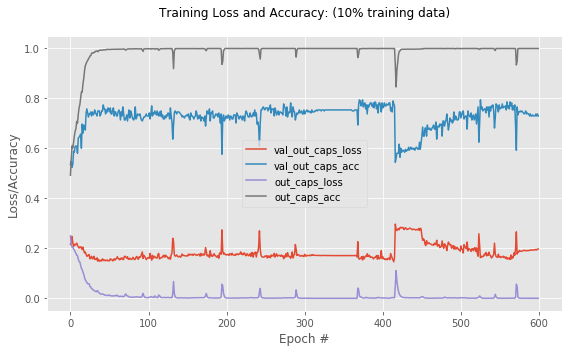


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.135    | 0.818    | 0.822     | 0.812    | 0.817   

-------------------------------
Testing with filter sizes [8, 32]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------
Train on 892 samples, validate on 99 samples
Epoch 1/1500
892/892 [==============================] - 3s 3ms/step - loss: 0.2564 - out_caps_loss: 0.2564 - out_recon_loss: 0.0894 - out_caps_acc: 0.5415 - out_recon_acc: 0.3370 - val_loss: 0.2113 - val_out_caps_loss: 0.2113 - val_out_recon_loss: 0.0899 - val_out_caps_acc: 0.6061 - val_out_recon_acc: 0.3415
Epoch 2/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.2145 - out_caps_loss: 0.2145 - out_recon_loss: 0.0894 - out_caps_acc: 0.5762 - out_recon_acc: 0.3374 - val_loss: 0.2139 - val_out_caps_loss: 0.2139 - val_out_recon_loss: 0.

Epoch 26/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0742 - out_caps_loss: 0.0741 - out_recon_loss: 0.0357 - out_caps_acc: 0.9204 - out_recon_acc: 0.5332 - val_loss: 0.1610 - val_out_caps_loss: 0.1609 - val_out_recon_loss: 0.0356 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.5160
Epoch 27/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0693 - out_caps_loss: 0.0693 - out_recon_loss: 0.0355 - out_caps_acc: 0.9361 - out_recon_acc: 0.5307 - val_loss: 0.1757 - val_out_caps_loss: 0.1757 - val_out_recon_loss: 0.0354 - val_out_caps_acc: 0.7273 - val_out_recon_acc: 0.5142
Epoch 28/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0687 - out_caps_loss: 0.0687 - out_recon_loss: 0.0353 - out_caps_acc: 0.9215 - out_recon_acc: 0.5287 - val_loss: 0.1697 - val_out_caps_loss: 0.1696 - val_out_recon_loss: 0.0353 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.5121
Epoch 29/1500
892/892 [==============================] - 2s 2ms/ste

892/892 [==============================] - 2s 2ms/step - loss: 0.0150 - out_caps_loss: 0.0149 - out_recon_loss: 0.0348 - out_caps_acc: 1.0000 - out_recon_acc: 0.5112 - val_loss: 0.1518 - val_out_caps_loss: 0.1518 - val_out_recon_loss: 0.0348 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4953
Epoch 53/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0149 - out_caps_loss: 0.0149 - out_recon_loss: 0.0348 - out_caps_acc: 0.9978 - out_recon_acc: 0.5108 - val_loss: 0.1544 - val_out_caps_loss: 0.1544 - val_out_recon_loss: 0.0348 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4950
Epoch 54/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0175 - out_caps_loss: 0.0174 - out_recon_loss: 0.0348 - out_caps_acc: 0.9989 - out_recon_acc: 0.5105 - val_loss: 0.1572 - val_out_caps_loss: 0.1572 - val_out_recon_loss: 0.0347 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4946
Epoch 55/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.01

892/892 [==============================] - 2s 2ms/step - loss: 0.0053 - out_caps_loss: 0.0052 - out_recon_loss: 0.0346 - out_caps_acc: 1.0000 - out_recon_acc: 0.5044 - val_loss: 0.1510 - val_out_caps_loss: 0.1510 - val_out_recon_loss: 0.0346 - val_out_caps_acc: 0.7576 - val_out_recon_acc: 0.4885
Epoch 79/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0047 - out_caps_loss: 0.0047 - out_recon_loss: 0.0346 - out_caps_acc: 1.0000 - out_recon_acc: 0.5043 - val_loss: 0.1514 - val_out_caps_loss: 0.1514 - val_out_recon_loss: 0.0347 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4884
Epoch 80/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0050 - out_caps_loss: 0.0049 - out_recon_loss: 0.0346 - out_caps_acc: 1.0000 - out_recon_acc: 0.5041 - val_loss: 0.1526 - val_out_caps_loss: 0.1526 - val_out_recon_loss: 0.0346 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4882
Epoch 81/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.00

892/892 [==============================] - 2s 2ms/step - loss: 0.0038 - out_caps_loss: 0.0038 - out_recon_loss: 0.0344 - out_caps_acc: 0.9989 - out_recon_acc: 0.5030 - val_loss: 0.1562 - val_out_caps_loss: 0.1562 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4868
Epoch 105/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0040 - out_caps_loss: 0.0039 - out_recon_loss: 0.0344 - out_caps_acc: 1.0000 - out_recon_acc: 0.5029 - val_loss: 0.1503 - val_out_caps_loss: 0.1503 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4867
Epoch 106/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0037 - out_caps_loss: 0.0037 - out_recon_loss: 0.0344 - out_caps_acc: 1.0000 - out_recon_acc: 0.5029 - val_loss: 0.1626 - val_out_caps_loss: 0.1626 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.7576 - val_out_recon_acc: 0.4868
Epoch 107/1500
892/892 [==============================] - 2s 2ms/step - loss: 0

892/892 [==============================] - 2s 2ms/step - loss: 0.0047 - out_caps_loss: 0.0046 - out_recon_loss: 0.0341 - out_caps_acc: 1.0000 - out_recon_acc: 0.5036 - val_loss: 0.1570 - val_out_caps_loss: 0.1570 - val_out_recon_loss: 0.0341 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4871
Epoch 131/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0040 - out_caps_loss: 0.0040 - out_recon_loss: 0.0341 - out_caps_acc: 1.0000 - out_recon_acc: 0.5035 - val_loss: 0.1471 - val_out_caps_loss: 0.1471 - val_out_recon_loss: 0.0341 - val_out_caps_acc: 0.7778 - val_out_recon_acc: 0.4873
Epoch 132/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0041 - out_caps_loss: 0.0041 - out_recon_loss: 0.0341 - out_caps_acc: 1.0000 - out_recon_acc: 0.5037 - val_loss: 0.1527 - val_out_caps_loss: 0.1527 - val_out_recon_loss: 0.0340 - val_out_caps_acc: 0.7576 - val_out_recon_acc: 0.4870
Epoch 133/1500
892/892 [==============================] - 2s 2ms/step - loss: 0

892/892 [==============================] - 2s 2ms/step - loss: 0.0023 - out_caps_loss: 0.0023 - out_recon_loss: 0.0338 - out_caps_acc: 1.0000 - out_recon_acc: 0.5040 - val_loss: 0.1553 - val_out_caps_loss: 0.1553 - val_out_recon_loss: 0.0337 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4874
Epoch 157/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0034 - out_caps_loss: 0.0033 - out_recon_loss: 0.0337 - out_caps_acc: 1.0000 - out_recon_acc: 0.5041 - val_loss: 0.1463 - val_out_caps_loss: 0.1463 - val_out_recon_loss: 0.0337 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4874
Epoch 158/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0034 - out_caps_loss: 0.0033 - out_recon_loss: 0.0337 - out_caps_acc: 1.0000 - out_recon_acc: 0.5040 - val_loss: 0.1553 - val_out_caps_loss: 0.1553 - val_out_recon_loss: 0.0336 - val_out_caps_acc: 0.7576 - val_out_recon_acc: 0.4873
Epoch 159/1500
892/892 [==============================] - 2s 2ms/step - loss: 0

892/892 [==============================] - 2s 2ms/step - loss: 9.1327e-04 - out_caps_loss: 8.9670e-04 - out_recon_loss: 0.0331 - out_caps_acc: 1.0000 - out_recon_acc: 0.5047 - val_loss: 0.1540 - val_out_caps_loss: 0.1540 - val_out_recon_loss: 0.0331 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4880
Epoch 183/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0015 - out_caps_loss: 0.0014 - out_recon_loss: 0.0331 - out_caps_acc: 1.0000 - out_recon_acc: 0.5047 - val_loss: 0.1660 - val_out_caps_loss: 0.1660 - val_out_recon_loss: 0.0331 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4880
Epoch 184/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0015 - out_caps_loss: 0.0014 - out_recon_loss: 0.0331 - out_caps_acc: 1.0000 - out_recon_acc: 0.5047 - val_loss: 0.1567 - val_out_caps_loss: 0.1567 - val_out_recon_loss: 0.0331 - val_out_caps_acc: 0.7273 - val_out_recon_acc: 0.4880
Epoch 185/1500
892/892 [==============================] - 2s 2ms/step -

892/892 [==============================] - 2s 2ms/step - loss: 0.0019 - out_caps_loss: 0.0019 - out_recon_loss: 0.0326 - out_caps_acc: 1.0000 - out_recon_acc: 0.5060 - val_loss: 0.1551 - val_out_caps_loss: 0.1551 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4895
Epoch 209/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0026 - out_caps_loss: 0.0026 - out_recon_loss: 0.0326 - out_caps_acc: 1.0000 - out_recon_acc: 0.5062 - val_loss: 0.1556 - val_out_caps_loss: 0.1556 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4897
Epoch 210/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0026 - out_caps_loss: 0.0026 - out_recon_loss: 0.0325 - out_caps_acc: 1.0000 - out_recon_acc: 0.5064 - val_loss: 0.1538 - val_out_caps_loss: 0.1538 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7576 - val_out_recon_acc: 0.4896
Epoch 211/1500
892/892 [==============================] - 2s 2ms/step - loss: 0

892/892 [==============================] - 2s 2ms/step - loss: 0.0036 - out_caps_loss: 0.0036 - out_recon_loss: 0.0322 - out_caps_acc: 1.0000 - out_recon_acc: 0.5070 - val_loss: 0.1708 - val_out_caps_loss: 0.1708 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4898
Epoch 235/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0028 - out_caps_loss: 0.0028 - out_recon_loss: 0.0321 - out_caps_acc: 1.0000 - out_recon_acc: 0.5068 - val_loss: 0.1667 - val_out_caps_loss: 0.1667 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4903
Epoch 236/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0029 - out_caps_loss: 0.0029 - out_recon_loss: 0.0322 - out_caps_acc: 1.0000 - out_recon_acc: 0.5068 - val_loss: 0.1662 - val_out_caps_loss: 0.1662 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4899
Epoch 237/1500
892/892 [==============================] - 2s 2ms/step - loss: 0

Epoch 260/1500
892/892 [==============================] - 2s 2ms/step - loss: 2.4272e-05 - out_caps_loss: 8.3292e-06 - out_recon_loss: 0.0319 - out_caps_acc: 1.0000 - out_recon_acc: 0.5072 - val_loss: 0.1596 - val_out_caps_loss: 0.1596 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4913
Epoch 261/1500
892/892 [==============================] - 2s 2ms/step - loss: 2.3189e-05 - out_caps_loss: 7.2466e-06 - out_recon_loss: 0.0319 - out_caps_acc: 1.0000 - out_recon_acc: 0.5071 - val_loss: 0.1593 - val_out_caps_loss: 0.1593 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4913
Epoch 262/1500
892/892 [==============================] - 2s 2ms/step - loss: 2.2723e-05 - out_caps_loss: 6.7891e-06 - out_recon_loss: 0.0319 - out_caps_acc: 1.0000 - out_recon_acc: 0.5071 - val_loss: 0.1597 - val_out_caps_loss: 0.1597 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4912
Epoch 263/1500
892/892 [================

Epoch 286/1500
892/892 [==============================] - 1s 2ms/step - loss: 1.6840e-05 - out_caps_loss: 9.8374e-07 - out_recon_loss: 0.0317 - out_caps_acc: 1.0000 - out_recon_acc: 0.5065 - val_loss: 0.1614 - val_out_caps_loss: 0.1614 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4909
Epoch 287/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.6745e-05 - out_caps_loss: 8.9051e-07 - out_recon_loss: 0.0317 - out_caps_acc: 1.0000 - out_recon_acc: 0.5064 - val_loss: 0.1615 - val_out_caps_loss: 0.1615 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4909
Epoch 288/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.6659e-05 - out_caps_loss: 8.0452e-07 - out_recon_loss: 0.0317 - out_caps_acc: 1.0000 - out_recon_acc: 0.5065 - val_loss: 0.1615 - val_out_caps_loss: 0.1615 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4908
Epoch 289/1500
892/892 [================

Epoch 312/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5960e-05 - out_caps_loss: 1.8004e-07 - out_recon_loss: 0.0316 - out_caps_acc: 1.0000 - out_recon_acc: 0.5060 - val_loss: 0.1622 - val_out_caps_loss: 0.1622 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4904
Epoch 313/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5949e-05 - out_caps_loss: 1.7215e-07 - out_recon_loss: 0.0316 - out_caps_acc: 1.0000 - out_recon_acc: 0.5060 - val_loss: 0.1622 - val_out_caps_loss: 0.1622 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4903
Epoch 314/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5934e-05 - out_caps_loss: 1.5841e-07 - out_recon_loss: 0.0316 - out_caps_acc: 1.0000 - out_recon_acc: 0.5059 - val_loss: 0.1623 - val_out_caps_loss: 0.1623 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4904
Epoch 315/1500
892/892 [================

Epoch 338/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5748e-05 - out_caps_loss: 3.7108e-08 - out_recon_loss: 0.0314 - out_caps_acc: 1.0000 - out_recon_acc: 0.5057 - val_loss: 0.1625 - val_out_caps_loss: 0.1624 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4902
Epoch 339/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5744e-05 - out_caps_loss: 3.3526e-08 - out_recon_loss: 0.0314 - out_caps_acc: 1.0000 - out_recon_acc: 0.5057 - val_loss: 0.1625 - val_out_caps_loss: 0.1625 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4902
Epoch 340/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5736e-05 - out_caps_loss: 3.1252e-08 - out_recon_loss: 0.0314 - out_caps_acc: 1.0000 - out_recon_acc: 0.5056 - val_loss: 0.1625 - val_out_caps_loss: 0.1625 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4903
Epoch 341/1500
892/892 [================

Epoch 364/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5656e-05 - out_caps_loss: 7.0254e-09 - out_recon_loss: 0.0313 - out_caps_acc: 1.0000 - out_recon_acc: 0.5056 - val_loss: 0.1626 - val_out_caps_loss: 0.1626 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4904
Epoch 365/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5653e-05 - out_caps_loss: 5.8878e-09 - out_recon_loss: 0.0313 - out_caps_acc: 1.0000 - out_recon_acc: 0.5055 - val_loss: 0.1626 - val_out_caps_loss: 0.1626 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4904
Epoch 366/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5646e-05 - out_caps_loss: 5.1016e-09 - out_recon_loss: 0.0313 - out_caps_acc: 1.0000 - out_recon_acc: 0.5055 - val_loss: 0.1626 - val_out_caps_loss: 0.1626 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4905
Epoch 367/1500
892/892 [================

Epoch 390/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5577e-05 - out_caps_loss: 1.1389e-09 - out_recon_loss: 0.0312 - out_caps_acc: 1.0000 - out_recon_acc: 0.5058 - val_loss: 0.1627 - val_out_caps_loss: 0.1627 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4904
Epoch 391/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5576e-05 - out_caps_loss: 9.5170e-10 - out_recon_loss: 0.0312 - out_caps_acc: 1.0000 - out_recon_acc: 0.5056 - val_loss: 0.1627 - val_out_caps_loss: 0.1627 - val_out_recon_loss: 0.0319 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4904
Epoch 392/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5569e-05 - out_caps_loss: 1.1243e-09 - out_recon_loss: 0.0311 - out_caps_acc: 1.0000 - out_recon_acc: 0.5057 - val_loss: 0.1627 - val_out_caps_loss: 0.1627 - val_out_recon_loss: 0.0319 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4904
Epoch 393/1500
892/892 [================

Epoch 416/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5498e-05 - out_caps_loss: 5.7825e-10 - out_recon_loss: 0.0310 - out_caps_acc: 1.0000 - out_recon_acc: 0.5060 - val_loss: 0.1627 - val_out_caps_loss: 0.1627 - val_out_recon_loss: 0.0319 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4905
Epoch 417/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5495e-05 - out_caps_loss: 3.9945e-10 - out_recon_loss: 0.0310 - out_caps_acc: 1.0000 - out_recon_acc: 0.5062 - val_loss: 0.1627 - val_out_caps_loss: 0.1627 - val_out_recon_loss: 0.0319 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4906
Epoch 418/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5495e-05 - out_caps_loss: 1.4108e-09 - out_recon_loss: 0.0310 - out_caps_acc: 1.0000 - out_recon_acc: 0.5061 - val_loss: 0.1627 - val_out_caps_loss: 0.1627 - val_out_recon_loss: 0.0319 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4905
Epoch 419/1500
892/892 [================

Epoch 442/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5426e-05 - out_caps_loss: 1.1704e-08 - out_recon_loss: 0.0308 - out_caps_acc: 1.0000 - out_recon_acc: 0.5066 - val_loss: 0.1628 - val_out_caps_loss: 0.1628 - val_out_recon_loss: 0.0318 - val_out_caps_acc: 0.7273 - val_out_recon_acc: 0.4910
Epoch 443/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5483e-05 - out_caps_loss: 7.2836e-08 - out_recon_loss: 0.0308 - out_caps_acc: 1.0000 - out_recon_acc: 0.5066 - val_loss: 0.1619 - val_out_caps_loss: 0.1619 - val_out_recon_loss: 0.0318 - val_out_caps_acc: 0.7273 - val_out_recon_acc: 0.4910
Epoch 444/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5866e-05 - out_caps_loss: 4.5660e-07 - out_recon_loss: 0.0308 - out_caps_acc: 1.0000 - out_recon_acc: 0.5065 - val_loss: 0.1649 - val_out_caps_loss: 0.1649 - val_out_recon_loss: 0.0319 - val_out_caps_acc: 0.7172 - val_out_recon_acc: 0.4909
Epoch 445/1500
892/892 [================

892/892 [==============================] - 2s 2ms/step - loss: 0.0011 - out_caps_loss: 0.0010 - out_recon_loss: 0.0311 - out_caps_acc: 1.0000 - out_recon_acc: 0.5073 - val_loss: 0.1815 - val_out_caps_loss: 0.1815 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7172 - val_out_recon_acc: 0.4913
Epoch 469/1500
892/892 [==============================] - 2s 2ms/step - loss: 5.3761e-04 - out_caps_loss: 5.2208e-04 - out_recon_loss: 0.0311 - out_caps_acc: 1.0000 - out_recon_acc: 0.5073 - val_loss: 0.1730 - val_out_caps_loss: 0.1729 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7576 - val_out_recon_acc: 0.4910
Epoch 470/1500
892/892 [==============================] - 2s 2ms/step - loss: 6.6872e-04 - out_caps_loss: 6.5318e-04 - out_recon_loss: 0.0311 - out_caps_acc: 1.0000 - out_recon_acc: 0.5073 - val_loss: 0.1816 - val_out_caps_loss: 0.1815 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7071 - val_out_recon_acc: 0.4915
Epoch 471/1500
892/892 [==============================] - 2s 2m

892/892 [==============================] - 2s 2ms/step - loss: 0.0013 - out_caps_loss: 0.0013 - out_recon_loss: 0.0310 - out_caps_acc: 1.0000 - out_recon_acc: 0.5073 - val_loss: 0.1755 - val_out_caps_loss: 0.1755 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7273 - val_out_recon_acc: 0.4912
Epoch 495/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0015 - out_caps_loss: 0.0015 - out_recon_loss: 0.0310 - out_caps_acc: 1.0000 - out_recon_acc: 0.5072 - val_loss: 0.1761 - val_out_caps_loss: 0.1761 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7273 - val_out_recon_acc: 0.4912
Epoch 496/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0016 - out_caps_loss: 0.0016 - out_recon_loss: 0.0310 - out_caps_acc: 1.0000 - out_recon_acc: 0.5072 - val_loss: 0.1838 - val_out_caps_loss: 0.1838 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7273 - val_out_recon_acc: 0.4916
Epoch 497/1500
892/892 [==============================] - 2s 2ms/step - loss: 0

892/892 [==============================] - 2s 2ms/step - loss: 4.8494e-04 - out_caps_loss: 4.6951e-04 - out_recon_loss: 0.0309 - out_caps_acc: 1.0000 - out_recon_acc: 0.5074 - val_loss: 0.1792 - val_out_caps_loss: 0.1792 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.7273 - val_out_recon_acc: 0.4918
Epoch 521/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0011 - out_caps_loss: 0.0011 - out_recon_loss: 0.0308 - out_caps_acc: 1.0000 - out_recon_acc: 0.5074 - val_loss: 0.1718 - val_out_caps_loss: 0.1718 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4913
Epoch 522/1500
892/892 [==============================] - 2s 2ms/step - loss: 6.8296e-04 - out_caps_loss: 6.6753e-04 - out_recon_loss: 0.0309 - out_caps_acc: 1.0000 - out_recon_acc: 0.5074 - val_loss: 0.1799 - val_out_caps_loss: 0.1799 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.6970 - val_out_recon_acc: 0.4913
Epoch 523/1500
892/892 [==============================] - 2s 2m

Epoch 546/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0027 - out_caps_loss: 0.0027 - out_recon_loss: 0.0309 - out_caps_acc: 1.0000 - out_recon_acc: 0.5079 - val_loss: 0.1830 - val_out_caps_loss: 0.1830 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.6768 - val_out_recon_acc: 0.4922
Epoch 547/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0020 - out_caps_loss: 0.0020 - out_recon_loss: 0.0309 - out_caps_acc: 1.0000 - out_recon_acc: 0.5077 - val_loss: 0.1772 - val_out_caps_loss: 0.1772 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7273 - val_out_recon_acc: 0.4916
Epoch 548/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0012 - out_caps_loss: 0.0012 - out_recon_loss: 0.0308 - out_caps_acc: 1.0000 - out_recon_acc: 0.5076 - val_loss: 0.1670 - val_out_caps_loss: 0.1670 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7273 - val_out_recon_acc: 0.4916
Epoch 549/1500
892/892 [==============================] - 2s 2ms

Epoch 572/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0060 - out_caps_loss: 0.0060 - out_recon_loss: 0.0308 - out_caps_acc: 1.0000 - out_recon_acc: 0.5078 - val_loss: 0.1881 - val_out_caps_loss: 0.1881 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.6970 - val_out_recon_acc: 0.4925
Epoch 573/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0089 - out_caps_loss: 0.0089 - out_recon_loss: 0.0310 - out_caps_acc: 0.9966 - out_recon_acc: 0.5079 - val_loss: 0.2912 - val_out_caps_loss: 0.2912 - val_out_recon_loss: 0.0357 - val_out_caps_acc: 0.6061 - val_out_recon_acc: 0.4919
Epoch 574/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0349 - out_caps_loss: 0.0349 - out_recon_loss: 0.0314 - out_caps_acc: 0.9652 - out_recon_acc: 0.5087 - val_loss: 0.1905 - val_out_caps_loss: 0.1904 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4926
Epoch 575/1500
892/892 [==============================] - 2s 2ms

Epoch 598/1500
892/892 [==============================] - 2s 2ms/step - loss: 2.3120e-05 - out_caps_loss: 7.7446e-06 - out_recon_loss: 0.0308 - out_caps_acc: 1.0000 - out_recon_acc: 0.5084 - val_loss: 0.1725 - val_out_caps_loss: 0.1724 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4923
Epoch 599/1500
892/892 [==============================] - 2s 2ms/step - loss: 2.2524e-05 - out_caps_loss: 7.1493e-06 - out_recon_loss: 0.0307 - out_caps_acc: 1.0000 - out_recon_acc: 0.5084 - val_loss: 0.1726 - val_out_caps_loss: 0.1725 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4924
Epoch 600/1500
892/892 [==============================] - 2s 2ms/step - loss: 2.1893e-05 - out_caps_loss: 6.5219e-06 - out_recon_loss: 0.0307 - out_caps_acc: 1.0000 - out_recon_acc: 0.5083 - val_loss: 0.1726 - val_out_caps_loss: 0.1726 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4923
Epoch 601/1500
892/892 [================

Epoch 624/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.6581e-05 - out_caps_loss: 1.2385e-06 - out_recon_loss: 0.0307 - out_caps_acc: 1.0000 - out_recon_acc: 0.5085 - val_loss: 0.1741 - val_out_caps_loss: 0.1741 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4923
Epoch 625/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.6508e-05 - out_caps_loss: 1.1682e-06 - out_recon_loss: 0.0307 - out_caps_acc: 1.0000 - out_recon_acc: 0.5083 - val_loss: 0.1741 - val_out_caps_loss: 0.1741 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4924
Epoch 626/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.6410e-05 - out_caps_loss: 1.0776e-06 - out_recon_loss: 0.0307 - out_caps_acc: 1.0000 - out_recon_acc: 0.5084 - val_loss: 0.1742 - val_out_caps_loss: 0.1741 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4923
Epoch 627/1500
892/892 [================

Epoch 650/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5604e-05 - out_caps_loss: 2.9786e-07 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5084 - val_loss: 0.1745 - val_out_caps_loss: 0.1745 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4921
Epoch 651/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5591e-05 - out_caps_loss: 2.8907e-07 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5084 - val_loss: 0.1746 - val_out_caps_loss: 0.1745 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4922
Epoch 652/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5583e-05 - out_caps_loss: 2.8607e-07 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5084 - val_loss: 0.1746 - val_out_caps_loss: 0.1746 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4922
Epoch 653/1500
892/892 [================

Epoch 676/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5344e-05 - out_caps_loss: 8.0650e-08 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5083 - val_loss: 0.1747 - val_out_caps_loss: 0.1747 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4921
Epoch 677/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5337e-05 - out_caps_loss: 7.5473e-08 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5083 - val_loss: 0.1747 - val_out_caps_loss: 0.1746 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4921
Epoch 678/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5334e-05 - out_caps_loss: 7.1538e-08 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5084 - val_loss: 0.1747 - val_out_caps_loss: 0.1747 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4921
Epoch 679/1500
892/892 [================

Epoch 702/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5242e-05 - out_caps_loss: 1.7594e-08 - out_recon_loss: 0.0304 - out_caps_acc: 1.0000 - out_recon_acc: 0.5082 - val_loss: 0.1746 - val_out_caps_loss: 0.1746 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4920
Epoch 703/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5238e-05 - out_caps_loss: 1.5745e-08 - out_recon_loss: 0.0304 - out_caps_acc: 1.0000 - out_recon_acc: 0.5082 - val_loss: 0.1746 - val_out_caps_loss: 0.1746 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4920
Epoch 704/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5237e-05 - out_caps_loss: 1.5859e-08 - out_recon_loss: 0.0304 - out_caps_acc: 1.0000 - out_recon_acc: 0.5082 - val_loss: 0.1746 - val_out_caps_loss: 0.1746 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4919
Epoch 705/1500
892/892 [================

Epoch 728/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5176e-05 - out_caps_loss: 4.2564e-09 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5081 - val_loss: 0.1745 - val_out_caps_loss: 0.1745 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4919
Epoch 729/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5181e-05 - out_caps_loss: 4.8312e-09 - out_recon_loss: 0.0304 - out_caps_acc: 1.0000 - out_recon_acc: 0.5080 - val_loss: 0.1744 - val_out_caps_loss: 0.1744 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4918
Epoch 730/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5174e-05 - out_caps_loss: 4.6998e-09 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5081 - val_loss: 0.1744 - val_out_caps_loss: 0.1744 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4918
Epoch 731/1500
892/892 [================

Epoch 754/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0014 - out_caps_loss: 0.0014 - out_recon_loss: 0.0308 - out_caps_acc: 0.9978 - out_recon_acc: 0.5078 - val_loss: 0.1699 - val_out_caps_loss: 0.1699 - val_out_recon_loss: 0.0334 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4923
Epoch 755/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0016 - out_caps_loss: 0.0016 - out_recon_loss: 0.0308 - out_caps_acc: 0.9978 - out_recon_acc: 0.5077 - val_loss: 0.1684 - val_out_caps_loss: 0.1684 - val_out_recon_loss: 0.0334 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4923
Epoch 756/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0019 - out_caps_loss: 0.0019 - out_recon_loss: 0.0308 - out_caps_acc: 0.9966 - out_recon_acc: 0.5077 - val_loss: 0.1665 - val_out_caps_loss: 0.1664 - val_out_recon_loss: 0.0333 - val_out_caps_acc: 0.7980 - val_out_recon_acc: 0.4922
Epoch 757/1500
892/892 [==============================] - 2s 2ms

892/892 [==============================] - 2s 2ms/step - loss: 3.0892e-04 - out_caps_loss: 2.9358e-04 - out_recon_loss: 0.0307 - out_caps_acc: 1.0000 - out_recon_acc: 0.5072 - val_loss: 0.1625 - val_out_caps_loss: 0.1625 - val_out_recon_loss: 0.0332 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4916
Epoch 781/1500
892/892 [==============================] - 2s 2ms/step - loss: 4.9377e-04 - out_caps_loss: 4.7842e-04 - out_recon_loss: 0.0307 - out_caps_acc: 1.0000 - out_recon_acc: 0.5072 - val_loss: 0.1635 - val_out_caps_loss: 0.1635 - val_out_recon_loss: 0.0330 - val_out_caps_acc: 0.8081 - val_out_recon_acc: 0.4916
Epoch 782/1500
892/892 [==============================] - 2s 2ms/step - loss: 6.3468e-04 - out_caps_loss: 6.1934e-04 - out_recon_loss: 0.0307 - out_caps_acc: 1.0000 - out_recon_acc: 0.5071 - val_loss: 0.1721 - val_out_caps_loss: 0.1721 - val_out_recon_loss: 0.0331 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4918
Epoch 783/1500
892/892 [==============================]

Epoch 806/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0016 - out_caps_loss: 0.0016 - out_recon_loss: 0.0307 - out_caps_acc: 0.9989 - out_recon_acc: 0.5068 - val_loss: 0.1772 - val_out_caps_loss: 0.1772 - val_out_recon_loss: 0.0334 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4914
Epoch 807/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0013 - out_caps_loss: 0.0013 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5070 - val_loss: 0.1752 - val_out_caps_loss: 0.1752 - val_out_recon_loss: 0.0331 - val_out_caps_acc: 0.7778 - val_out_recon_acc: 0.4915
Epoch 808/1500
892/892 [==============================] - 2s 2ms/step - loss: 7.5571e-04 - out_caps_loss: 7.4040e-04 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5069 - val_loss: 0.1630 - val_out_caps_loss: 0.1630 - val_out_recon_loss: 0.0330 - val_out_caps_acc: 0.8384 - val_out_recon_acc: 0.4913
Epoch 809/1500
892/892 [==============================] 

Epoch 832/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0014 - out_caps_loss: 0.0014 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5065 - val_loss: 0.1743 - val_out_caps_loss: 0.1743 - val_out_recon_loss: 0.0336 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4910
Epoch 833/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0012 - out_caps_loss: 0.0012 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5066 - val_loss: 0.1604 - val_out_caps_loss: 0.1603 - val_out_recon_loss: 0.0332 - val_out_caps_acc: 0.7778 - val_out_recon_acc: 0.4911
Epoch 834/1500
892/892 [==============================] - 2s 2ms/step - loss: 8.8115e-04 - out_caps_loss: 8.6586e-04 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5066 - val_loss: 0.1828 - val_out_caps_loss: 0.1828 - val_out_recon_loss: 0.0332 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4910
Epoch 835/1500
892/892 [==============================] 

Epoch 858/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5758e-05 - out_caps_loss: 5.2674e-07 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5066 - val_loss: 0.1641 - val_out_caps_loss: 0.1641 - val_out_recon_loss: 0.0330 - val_out_caps_acc: 0.8081 - val_out_recon_acc: 0.4911
Epoch 859/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5733e-05 - out_caps_loss: 5.0427e-07 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5067 - val_loss: 0.1640 - val_out_caps_loss: 0.1640 - val_out_recon_loss: 0.0330 - val_out_caps_acc: 0.7980 - val_out_recon_acc: 0.4911
Epoch 860/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5707e-05 - out_caps_loss: 4.8048e-07 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5067 - val_loss: 0.1640 - val_out_caps_loss: 0.1640 - val_out_recon_loss: 0.0330 - val_out_caps_acc: 0.8081 - val_out_recon_acc: 0.4912
Epoch 861/1500
892/892 [================

Epoch 884/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5263e-05 - out_caps_loss: 7.0653e-08 - out_recon_loss: 0.0304 - out_caps_acc: 1.0000 - out_recon_acc: 0.5067 - val_loss: 0.1637 - val_out_caps_loss: 0.1637 - val_out_recon_loss: 0.0330 - val_out_caps_acc: 0.8081 - val_out_recon_acc: 0.4911
Epoch 885/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5260e-05 - out_caps_loss: 7.0186e-08 - out_recon_loss: 0.0304 - out_caps_acc: 1.0000 - out_recon_acc: 0.5067 - val_loss: 0.1636 - val_out_caps_loss: 0.1636 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.8081 - val_out_recon_acc: 0.4911
Epoch 886/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5244e-05 - out_caps_loss: 5.7994e-08 - out_recon_loss: 0.0304 - out_caps_acc: 1.0000 - out_recon_acc: 0.5067 - val_loss: 0.1635 - val_out_caps_loss: 0.1635 - val_out_recon_loss: 0.0330 - val_out_caps_acc: 0.8182 - val_out_recon_acc: 0.4911
Epoch 887/1500
892/892 [================

Epoch 910/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5157e-05 - out_caps_loss: 9.8204e-09 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5068 - val_loss: 0.1633 - val_out_caps_loss: 0.1633 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.8182 - val_out_recon_acc: 0.4911
Epoch 911/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5157e-05 - out_caps_loss: 8.5294e-09 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5068 - val_loss: 0.1633 - val_out_caps_loss: 0.1633 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.8182 - val_out_recon_acc: 0.4911
Epoch 912/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5158e-05 - out_caps_loss: 8.4060e-09 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5067 - val_loss: 0.1633 - val_out_caps_loss: 0.1633 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.8182 - val_out_recon_acc: 0.4910
Epoch 913/1500
892/892 [================

Epoch 936/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5096e-05 - out_caps_loss: 1.3533e-09 - out_recon_loss: 0.0302 - out_caps_acc: 1.0000 - out_recon_acc: 0.5069 - val_loss: 0.1633 - val_out_caps_loss: 0.1632 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.8182 - val_out_recon_acc: 0.4911
Epoch 937/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5093e-05 - out_caps_loss: 1.0567e-09 - out_recon_loss: 0.0302 - out_caps_acc: 1.0000 - out_recon_acc: 0.5069 - val_loss: 0.1632 - val_out_caps_loss: 0.1632 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.8182 - val_out_recon_acc: 0.4910
Epoch 938/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5088e-05 - out_caps_loss: 1.1953e-09 - out_recon_loss: 0.0302 - out_caps_acc: 1.0000 - out_recon_acc: 0.5068 - val_loss: 0.1633 - val_out_caps_loss: 0.1633 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.8182 - val_out_recon_acc: 0.4911
Epoch 939/1500
892/892 [================

Epoch 962/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5027e-05 - out_caps_loss: 2.0725e-10 - out_recon_loss: 0.0301 - out_caps_acc: 1.0000 - out_recon_acc: 0.5069 - val_loss: 0.1634 - val_out_caps_loss: 0.1634 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.8182 - val_out_recon_acc: 0.4910
Epoch 963/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5025e-05 - out_caps_loss: 1.9562e-10 - out_recon_loss: 0.0300 - out_caps_acc: 1.0000 - out_recon_acc: 0.5069 - val_loss: 0.1634 - val_out_caps_loss: 0.1634 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.8182 - val_out_recon_acc: 0.4911
Epoch 964/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5025e-05 - out_caps_loss: 4.0641e-10 - out_recon_loss: 0.0300 - out_caps_acc: 1.0000 - out_recon_acc: 0.5069 - val_loss: 0.1635 - val_out_caps_loss: 0.1635 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.8182 - val_out_recon_acc: 0.4909
Epoch 965/1500
892/892 [================

Epoch 988/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4951e-05 - out_caps_loss: 9.4516e-11 - out_recon_loss: 0.0299 - out_caps_acc: 1.0000 - out_recon_acc: 0.5068 - val_loss: 0.1637 - val_out_caps_loss: 0.1637 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.8182 - val_out_recon_acc: 0.4909
Epoch 989/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4947e-05 - out_caps_loss: 2.7427e-10 - out_recon_loss: 0.0299 - out_caps_acc: 1.0000 - out_recon_acc: 0.5070 - val_loss: 0.1637 - val_out_caps_loss: 0.1637 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.8182 - val_out_recon_acc: 0.4910
Epoch 990/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4940e-05 - out_caps_loss: 2.4814e-09 - out_recon_loss: 0.0299 - out_caps_acc: 1.0000 - out_recon_acc: 0.5068 - val_loss: 0.1638 - val_out_caps_loss: 0.1638 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.8182 - val_out_recon_acc: 0.4908
Epoch 991/1500
892/892 [================

Epoch 1014/1500
892/892 [==============================] - 2s 2ms/step - loss: 9.4296e-04 - out_caps_loss: 9.2781e-04 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5069 - val_loss: 0.1876 - val_out_caps_loss: 0.1875 - val_out_recon_loss: 0.0333 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4908
Epoch 1015/1500
892/892 [==============================] - 2s 2ms/step - loss: 8.7912e-04 - out_caps_loss: 8.6397e-04 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5070 - val_loss: 0.1763 - val_out_caps_loss: 0.1763 - val_out_recon_loss: 0.0331 - val_out_caps_acc: 0.7980 - val_out_recon_acc: 0.4906
Epoch 1016/1500
892/892 [==============================] - 2s 2ms/step - loss: 6.5533e-04 - out_caps_loss: 6.4019e-04 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5066 - val_loss: 0.1829 - val_out_caps_loss: 0.1829 - val_out_recon_loss: 0.0331 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4907
Epoch 1017/1500
892/892 [============

892/892 [==============================] - 2s 2ms/step - loss: 2.2378e-05 - out_caps_loss: 7.2994e-06 - out_recon_loss: 0.0302 - out_caps_acc: 1.0000 - out_recon_acc: 0.5065 - val_loss: 0.1742 - val_out_caps_loss: 0.1742 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4904
Epoch 1040/1500
892/892 [==============================] - 2s 2ms/step - loss: 2.1712e-05 - out_caps_loss: 6.6384e-06 - out_recon_loss: 0.0301 - out_caps_acc: 1.0000 - out_recon_acc: 0.5065 - val_loss: 0.1741 - val_out_caps_loss: 0.1741 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4905
Epoch 1041/1500
892/892 [==============================] - 2s 2ms/step - loss: 2.1124e-05 - out_caps_loss: 6.0503e-06 - out_recon_loss: 0.0301 - out_caps_acc: 1.0000 - out_recon_acc: 0.5066 - val_loss: 0.1739 - val_out_caps_loss: 0.1739 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4905
Epoch 1042/1500
892/892 [============================

892/892 [==============================] - 2s 2ms/step - loss: 1.6309e-05 - out_caps_loss: 1.2669e-06 - out_recon_loss: 0.0301 - out_caps_acc: 1.0000 - out_recon_acc: 0.5066 - val_loss: 0.1731 - val_out_caps_loss: 0.1731 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.7980 - val_out_recon_acc: 0.4905
Epoch 1065/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.6239e-05 - out_caps_loss: 1.1984e-06 - out_recon_loss: 0.0301 - out_caps_acc: 1.0000 - out_recon_acc: 0.5066 - val_loss: 0.1734 - val_out_caps_loss: 0.1734 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.7980 - val_out_recon_acc: 0.4905
Epoch 1066/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.6217e-05 - out_caps_loss: 1.1811e-06 - out_recon_loss: 0.0301 - out_caps_acc: 1.0000 - out_recon_acc: 0.5065 - val_loss: 0.1731 - val_out_caps_loss: 0.1731 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.7980 - val_out_recon_acc: 0.4903
Epoch 1067/1500
892/892 [============================

892/892 [==============================] - 2s 2ms/step - loss: 1.5332e-05 - out_caps_loss: 3.2646e-07 - out_recon_loss: 0.0300 - out_caps_acc: 1.0000 - out_recon_acc: 0.5066 - val_loss: 0.1729 - val_out_caps_loss: 0.1729 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4905
Epoch 1090/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5314e-05 - out_caps_loss: 3.1221e-07 - out_recon_loss: 0.0300 - out_caps_acc: 1.0000 - out_recon_acc: 0.5066 - val_loss: 0.1728 - val_out_caps_loss: 0.1728 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4905
Epoch 1091/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5302e-05 - out_caps_loss: 2.9646e-07 - out_recon_loss: 0.0300 - out_caps_acc: 1.0000 - out_recon_acc: 0.5066 - val_loss: 0.1727 - val_out_caps_loss: 0.1727 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4904
Epoch 1092/1500
892/892 [============================

892/892 [==============================] - 2s 2ms/step - loss: 1.5040e-05 - out_caps_loss: 7.6914e-08 - out_recon_loss: 0.0299 - out_caps_acc: 1.0000 - out_recon_acc: 0.5068 - val_loss: 0.1724 - val_out_caps_loss: 0.1724 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4906
Epoch 1115/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5039e-05 - out_caps_loss: 7.8340e-08 - out_recon_loss: 0.0299 - out_caps_acc: 1.0000 - out_recon_acc: 0.5066 - val_loss: 0.1723 - val_out_caps_loss: 0.1723 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4906
Epoch 1116/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5021e-05 - out_caps_loss: 6.6605e-08 - out_recon_loss: 0.0299 - out_caps_acc: 1.0000 - out_recon_acc: 0.5068 - val_loss: 0.1724 - val_out_caps_loss: 0.1724 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4907
Epoch 1117/1500
892/892 [============================

892/892 [==============================] - 2s 2ms/step - loss: 1.4931e-05 - out_caps_loss: 2.2569e-08 - out_recon_loss: 0.0298 - out_caps_acc: 1.0000 - out_recon_acc: 0.5068 - val_loss: 0.1723 - val_out_caps_loss: 0.1722 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4907
Epoch 1140/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4922e-05 - out_caps_loss: 1.9753e-08 - out_recon_loss: 0.0298 - out_caps_acc: 1.0000 - out_recon_acc: 0.5067 - val_loss: 0.1722 - val_out_caps_loss: 0.1722 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4907
Epoch 1141/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4923e-05 - out_caps_loss: 2.2290e-08 - out_recon_loss: 0.0298 - out_caps_acc: 1.0000 - out_recon_acc: 0.5068 - val_loss: 0.1724 - val_out_caps_loss: 0.1723 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4907
Epoch 1142/1500
892/892 [============================

892/892 [==============================] - 2s 2ms/step - loss: 1.4847e-05 - out_caps_loss: 2.9857e-09 - out_recon_loss: 0.0297 - out_caps_acc: 1.0000 - out_recon_acc: 0.5071 - val_loss: 0.1720 - val_out_caps_loss: 0.1720 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4911
Epoch 1165/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4848e-05 - out_caps_loss: 2.3600e-09 - out_recon_loss: 0.0297 - out_caps_acc: 1.0000 - out_recon_acc: 0.5070 - val_loss: 0.1720 - val_out_caps_loss: 0.1720 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4909
Epoch 1166/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4842e-05 - out_caps_loss: 2.4299e-09 - out_recon_loss: 0.0297 - out_caps_acc: 1.0000 - out_recon_acc: 0.5071 - val_loss: 0.1721 - val_out_caps_loss: 0.1721 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4910
Epoch 1167/1500
892/892 [============================

892/892 [==============================] - 2s 2ms/step - loss: 1.4775e-05 - out_caps_loss: 6.6002e-09 - out_recon_loss: 0.0295 - out_caps_acc: 1.0000 - out_recon_acc: 0.5073 - val_loss: 0.1720 - val_out_caps_loss: 0.1720 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4911
Epoch 1190/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4786e-05 - out_caps_loss: 2.1336e-08 - out_recon_loss: 0.0295 - out_caps_acc: 1.0000 - out_recon_acc: 0.5073 - val_loss: 0.1722 - val_out_caps_loss: 0.1722 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4911
Epoch 1191/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4788e-05 - out_caps_loss: 1.9079e-08 - out_recon_loss: 0.0295 - out_caps_acc: 1.0000 - out_recon_acc: 0.5073 - val_loss: 0.1722 - val_out_caps_loss: 0.1722 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.7879 - val_out_recon_acc: 0.4913
Epoch 1192/1500
892/892 [============================

Epoch 1215/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0065 - out_caps_loss: 0.0065 - out_recon_loss: 0.0301 - out_caps_acc: 0.9978 - out_recon_acc: 0.5071 - val_loss: 0.1595 - val_out_caps_loss: 0.1595 - val_out_recon_loss: 0.0332 - val_out_caps_acc: 0.7576 - val_out_recon_acc: 0.4907
Epoch 1216/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0034 - out_caps_loss: 0.0034 - out_recon_loss: 0.0301 - out_caps_acc: 1.0000 - out_recon_acc: 0.5073 - val_loss: 0.1866 - val_out_caps_loss: 0.1866 - val_out_recon_loss: 0.0333 - val_out_caps_acc: 0.7273 - val_out_recon_acc: 0.4912
Epoch 1217/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0024 - out_caps_loss: 0.0024 - out_recon_loss: 0.0300 - out_caps_acc: 1.0000 - out_recon_acc: 0.5072 - val_loss: 0.1715 - val_out_caps_loss: 0.1715 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4911
Epoch 1218/1500
892/892 [==============================] - 2s

Epoch 1241/1500
892/892 [==============================] - 2s 2ms/step - loss: 2.4250e-04 - out_caps_loss: 2.2759e-04 - out_recon_loss: 0.0298 - out_caps_acc: 1.0000 - out_recon_acc: 0.5075 - val_loss: 0.1924 - val_out_caps_loss: 0.1924 - val_out_recon_loss: 0.0332 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4912
Epoch 1242/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.0070e-04 - out_caps_loss: 8.5799e-05 - out_recon_loss: 0.0298 - out_caps_acc: 1.0000 - out_recon_acc: 0.5075 - val_loss: 0.1932 - val_out_caps_loss: 0.1931 - val_out_recon_loss: 0.0331 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4913
Epoch 1243/1500
892/892 [==============================] - 2s 2ms/step - loss: 2.9921e-04 - out_caps_loss: 2.8433e-04 - out_recon_loss: 0.0298 - out_caps_acc: 1.0000 - out_recon_acc: 0.5075 - val_loss: 0.1937 - val_out_caps_loss: 0.1937 - val_out_recon_loss: 0.0330 - val_out_caps_acc: 0.7273 - val_out_recon_acc: 0.4913
Epoch 1244/1500
892/892 [============

892/892 [==============================] - 2s 2ms/step - loss: 1.7376e-05 - out_caps_loss: 2.5220e-06 - out_recon_loss: 0.0297 - out_caps_acc: 1.0000 - out_recon_acc: 0.5073 - val_loss: 0.1930 - val_out_caps_loss: 0.1930 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4915
Epoch 1267/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.7262e-05 - out_caps_loss: 2.4131e-06 - out_recon_loss: 0.0297 - out_caps_acc: 1.0000 - out_recon_acc: 0.5077 - val_loss: 0.1932 - val_out_caps_loss: 0.1932 - val_out_recon_loss: 0.0331 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4912
Epoch 1268/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.7273e-05 - out_caps_loss: 2.4321e-06 - out_recon_loss: 0.0297 - out_caps_acc: 1.0000 - out_recon_acc: 0.5076 - val_loss: 0.1931 - val_out_caps_loss: 0.1931 - val_out_recon_loss: 0.0330 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4914
Epoch 1269/1500
892/892 [============================

892/892 [==============================] - 2s 2ms/step - loss: 1.5416e-05 - out_caps_loss: 6.0962e-07 - out_recon_loss: 0.0296 - out_caps_acc: 1.0000 - out_recon_acc: 0.5075 - val_loss: 0.1942 - val_out_caps_loss: 0.1942 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4913
Epoch 1292/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5422e-05 - out_caps_loss: 6.1651e-07 - out_recon_loss: 0.0296 - out_caps_acc: 1.0000 - out_recon_acc: 0.5076 - val_loss: 0.1938 - val_out_caps_loss: 0.1938 - val_out_recon_loss: 0.0330 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4913
Epoch 1293/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5352e-05 - out_caps_loss: 5.4973e-07 - out_recon_loss: 0.0296 - out_caps_acc: 1.0000 - out_recon_acc: 0.5076 - val_loss: 0.1940 - val_out_caps_loss: 0.1940 - val_out_recon_loss: 0.0330 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4914
Epoch 1294/1500
892/892 [============================

892/892 [==============================] - 2s 2ms/step - loss: 1.4952e-05 - out_caps_loss: 1.8285e-07 - out_recon_loss: 0.0295 - out_caps_acc: 1.0000 - out_recon_acc: 0.5076 - val_loss: 0.1941 - val_out_caps_loss: 0.1940 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4916
Epoch 1317/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4916e-05 - out_caps_loss: 1.5157e-07 - out_recon_loss: 0.0295 - out_caps_acc: 1.0000 - out_recon_acc: 0.5078 - val_loss: 0.1938 - val_out_caps_loss: 0.1938 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4916
Epoch 1318/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4905e-05 - out_caps_loss: 1.4687e-07 - out_recon_loss: 0.0295 - out_caps_acc: 1.0000 - out_recon_acc: 0.5078 - val_loss: 0.1939 - val_out_caps_loss: 0.1939 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4915
Epoch 1319/1500
892/892 [============================

892/892 [==============================] - 2s 2ms/step - loss: 1.4764e-05 - out_caps_loss: 5.2545e-08 - out_recon_loss: 0.0294 - out_caps_acc: 1.0000 - out_recon_acc: 0.5080 - val_loss: 0.1941 - val_out_caps_loss: 0.1941 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4915
Epoch 1342/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4757e-05 - out_caps_loss: 4.4877e-08 - out_recon_loss: 0.0294 - out_caps_acc: 1.0000 - out_recon_acc: 0.5078 - val_loss: 0.1941 - val_out_caps_loss: 0.1940 - val_out_recon_loss: 0.0329 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4916
Epoch 1343/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4758e-05 - out_caps_loss: 4.1944e-08 - out_recon_loss: 0.0294 - out_caps_acc: 1.0000 - out_recon_acc: 0.5079 - val_loss: 0.1941 - val_out_caps_loss: 0.1941 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4918
Epoch 1344/1500
892/892 [============================

892/892 [==============================] - 2s 2ms/step - loss: 1.4666e-05 - out_caps_loss: 1.4290e-08 - out_recon_loss: 0.0293 - out_caps_acc: 1.0000 - out_recon_acc: 0.5083 - val_loss: 0.1944 - val_out_caps_loss: 0.1944 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4919
Epoch 1367/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4663e-05 - out_caps_loss: 1.2018e-08 - out_recon_loss: 0.0293 - out_caps_acc: 1.0000 - out_recon_acc: 0.5082 - val_loss: 0.1943 - val_out_caps_loss: 0.1943 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4919
Epoch 1368/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4658e-05 - out_caps_loss: 9.8311e-09 - out_recon_loss: 0.0293 - out_caps_acc: 1.0000 - out_recon_acc: 0.5081 - val_loss: 0.1943 - val_out_caps_loss: 0.1943 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4918
Epoch 1369/1500
892/892 [============================

892/892 [==============================] - 2s 2ms/step - loss: 1.4590e-05 - out_caps_loss: 2.7158e-09 - out_recon_loss: 0.0292 - out_caps_acc: 1.0000 - out_recon_acc: 0.5083 - val_loss: 0.1944 - val_out_caps_loss: 0.1944 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4922
Epoch 1392/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4580e-05 - out_caps_loss: 2.6619e-09 - out_recon_loss: 0.0292 - out_caps_acc: 1.0000 - out_recon_acc: 0.5084 - val_loss: 0.1944 - val_out_caps_loss: 0.1944 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4920
Epoch 1393/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4578e-05 - out_caps_loss: 2.3653e-09 - out_recon_loss: 0.0292 - out_caps_acc: 1.0000 - out_recon_acc: 0.5084 - val_loss: 0.1944 - val_out_caps_loss: 0.1944 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4922
Epoch 1394/1500
892/892 [============================

Epoch 1417/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0033 - out_caps_loss: 0.0033 - out_recon_loss: 0.0296 - out_caps_acc: 1.0000 - out_recon_acc: 0.5077 - val_loss: 0.1855 - val_out_caps_loss: 0.1855 - val_out_recon_loss: 0.0335 - val_out_caps_acc: 0.7273 - val_out_recon_acc: 0.4916
Epoch 1418/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0020 - out_caps_loss: 0.0020 - out_recon_loss: 0.0295 - out_caps_acc: 1.0000 - out_recon_acc: 0.5078 - val_loss: 0.1789 - val_out_caps_loss: 0.1789 - val_out_recon_loss: 0.0334 - val_out_caps_acc: 0.7475 - val_out_recon_acc: 0.4914
Epoch 1419/1500
892/892 [==============================] - 2s 2ms/step - loss: 0.0012 - out_caps_loss: 0.0012 - out_recon_loss: 0.0295 - out_caps_acc: 1.0000 - out_recon_acc: 0.5079 - val_loss: 0.1801 - val_out_caps_loss: 0.1801 - val_out_recon_loss: 0.0335 - val_out_caps_acc: 0.7374 - val_out_recon_acc: 0.4914
Epoch 1420/1500
892/892 [==============================] - 2s

Epoch 1443/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.8893e-05 - out_caps_loss: 4.1818e-06 - out_recon_loss: 0.0294 - out_caps_acc: 1.0000 - out_recon_acc: 0.5083 - val_loss: 0.1903 - val_out_caps_loss: 0.1902 - val_out_recon_loss: 0.0334 - val_out_caps_acc: 0.7576 - val_out_recon_acc: 0.4917
Epoch 1444/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.8257e-05 - out_caps_loss: 3.5486e-06 - out_recon_loss: 0.0294 - out_caps_acc: 1.0000 - out_recon_acc: 0.5082 - val_loss: 0.1902 - val_out_caps_loss: 0.1901 - val_out_recon_loss: 0.0334 - val_out_caps_acc: 0.7576 - val_out_recon_acc: 0.4915
Epoch 1445/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.7961e-05 - out_caps_loss: 3.2525e-06 - out_recon_loss: 0.0294 - out_caps_acc: 1.0000 - out_recon_acc: 0.5081 - val_loss: 0.1903 - val_out_caps_loss: 0.1903 - val_out_recon_loss: 0.0333 - val_out_caps_acc: 0.7576 - val_out_recon_acc: 0.4917
Epoch 1446/1500
892/892 [============

892/892 [==============================] - 2s 2ms/step - loss: 1.5256e-05 - out_caps_loss: 5.8902e-07 - out_recon_loss: 0.0293 - out_caps_acc: 1.0000 - out_recon_acc: 0.5083 - val_loss: 0.1924 - val_out_caps_loss: 0.1924 - val_out_recon_loss: 0.0333 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4916
Epoch 1469/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5371e-05 - out_caps_loss: 7.1157e-07 - out_recon_loss: 0.0293 - out_caps_acc: 1.0000 - out_recon_acc: 0.5084 - val_loss: 0.1921 - val_out_caps_loss: 0.1921 - val_out_recon_loss: 0.0333 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4917
Epoch 1470/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.5195e-05 - out_caps_loss: 5.2964e-07 - out_recon_loss: 0.0293 - out_caps_acc: 1.0000 - out_recon_acc: 0.5084 - val_loss: 0.1919 - val_out_caps_loss: 0.1919 - val_out_recon_loss: 0.0333 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4916
Epoch 1471/1500
892/892 [============================

892/892 [==============================] - 2s 2ms/step - loss: 1.4773e-05 - out_caps_loss: 1.4948e-07 - out_recon_loss: 0.0292 - out_caps_acc: 1.0000 - out_recon_acc: 0.5085 - val_loss: 0.1922 - val_out_caps_loss: 0.1922 - val_out_recon_loss: 0.0331 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4919
Epoch 1494/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4745e-05 - out_caps_loss: 1.2848e-07 - out_recon_loss: 0.0292 - out_caps_acc: 1.0000 - out_recon_acc: 0.5087 - val_loss: 0.1921 - val_out_caps_loss: 0.1920 - val_out_recon_loss: 0.0331 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4922
Epoch 1495/1500
892/892 [==============================] - 2s 2ms/step - loss: 1.4736e-05 - out_caps_loss: 1.1838e-07 - out_recon_loss: 0.0292 - out_caps_acc: 1.0000 - out_recon_acc: 0.5085 - val_loss: 0.1920 - val_out_caps_loss: 0.1920 - val_out_recon_loss: 0.0331 - val_out_caps_acc: 0.7677 - val_out_recon_acc: 0.4921
Epoch 1496/1500
892/892 [============================

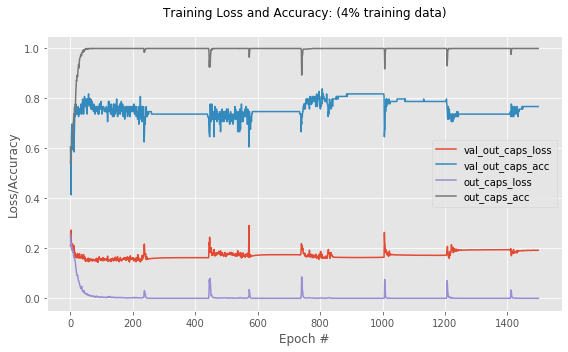


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.173    | 0.733    | 0.757     | 0.684    | 0.719   



In [42]:

for frac in [40, 10, 4]:
    fracTest(frac, K_SIZE, [8,32], 16, verbose=1)

-------------------------------
Testing with filter sizes [4, 8]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------
Train on 1116 samples, validate on 124 samples
Epoch 1/1200
1116/1116 [==============================] - 2s 2ms/step - loss: 0.2699 - out_caps_loss: 0.2698 - out_recon_loss: 0.0892 - out_caps_acc: 0.5036 - out_recon_acc: 0.3404 - val_loss: 0.2152 - val_out_caps_loss: 0.2152 - val_out_recon_loss: 0.0897 - val_out_caps_acc: 0.5161 - val_out_recon_acc: 0.3466
Epoch 2/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.2146 - out_caps_loss: 0.2146 - out_recon_loss: 0.0891 - out_caps_acc: 0.5152 - out_recon_acc: 0.3487 - val_loss: 0.2131 - val_out_caps_loss: 0.2131 - val_out_recon_loss: 0.0896 - val_out_caps_acc: 0.4839 - val_out_recon_acc: 0.3523
Epoch 3/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.2161 - out_caps_loss: 0.2161 - out_recon_loss: 0.0890 - out_caps_acc: 0.5251 - out_recon_ac

1116/1116 [==============================] - 1s 1ms/step - loss: 0.0626 - out_caps_loss: 0.0626 - out_recon_loss: 0.0348 - out_caps_acc: 0.9597 - out_recon_acc: 0.5049 - val_loss: 0.1743 - val_out_caps_loss: 0.1743 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.7581 - val_out_recon_acc: 0.5126
Epoch 53/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0642 - out_caps_loss: 0.0642 - out_recon_loss: 0.0348 - out_caps_acc: 0.9642 - out_recon_acc: 0.5047 - val_loss: 0.1582 - val_out_caps_loss: 0.1582 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.7823 - val_out_recon_acc: 0.5119
Epoch 54/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0595 - out_caps_loss: 0.0595 - out_recon_loss: 0.0348 - out_caps_acc: 0.9606 - out_recon_acc: 0.5044 - val_loss: 0.1600 - val_out_caps_loss: 0.1600 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.7581 - val_out_recon_acc: 0.5115
Epoch 55/1200
1116/1116 [==============================] - 1s 1ms/step - lo

1116/1116 [==============================] - 1s 1ms/step - loss: 0.0123 - out_caps_loss: 0.0123 - out_recon_loss: 0.0344 - out_caps_acc: 0.9892 - out_recon_acc: 0.5003 - val_loss: 0.1570 - val_out_caps_loss: 0.1570 - val_out_recon_loss: 0.0342 - val_out_caps_acc: 0.7903 - val_out_recon_acc: 0.5073
Epoch 105/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0117 - out_caps_loss: 0.0117 - out_recon_loss: 0.0344 - out_caps_acc: 0.9910 - out_recon_acc: 0.5003 - val_loss: 0.1621 - val_out_caps_loss: 0.1621 - val_out_recon_loss: 0.0341 - val_out_caps_acc: 0.7823 - val_out_recon_acc: 0.5074
Epoch 106/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0114 - out_caps_loss: 0.0113 - out_recon_loss: 0.0344 - out_caps_acc: 0.9910 - out_recon_acc: 0.5004 - val_loss: 0.1640 - val_out_caps_loss: 0.1640 - val_out_recon_loss: 0.0342 - val_out_caps_acc: 0.7823 - val_out_recon_acc: 0.5074
Epoch 107/1200
1116/1116 [==============================] - 1s 1ms/step -

1116/1116 [==============================] - 2s 1ms/step - loss: 0.0039 - out_caps_loss: 0.0039 - out_recon_loss: 0.0339 - out_caps_acc: 0.9964 - out_recon_acc: 0.4995 - val_loss: 0.1695 - val_out_caps_loss: 0.1695 - val_out_recon_loss: 0.0337 - val_out_caps_acc: 0.7823 - val_out_recon_acc: 0.5069
Epoch 157/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0035 - out_caps_loss: 0.0035 - out_recon_loss: 0.0339 - out_caps_acc: 0.9964 - out_recon_acc: 0.4995 - val_loss: 0.1686 - val_out_caps_loss: 0.1686 - val_out_recon_loss: 0.0337 - val_out_caps_acc: 0.7500 - val_out_recon_acc: 0.5068
Epoch 158/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0042 - out_caps_loss: 0.0042 - out_recon_loss: 0.0339 - out_caps_acc: 0.9964 - out_recon_acc: 0.4995 - val_loss: 0.1651 - val_out_caps_loss: 0.1650 - val_out_recon_loss: 0.0336 - val_out_caps_acc: 0.7581 - val_out_recon_acc: 0.5067
Epoch 159/1200
1116/1116 [==============================] - 2s 1ms/step -

1116/1116 [==============================] - 2s 1ms/step - loss: 0.0100 - out_caps_loss: 0.0100 - out_recon_loss: 0.0329 - out_caps_acc: 0.9955 - out_recon_acc: 0.5008 - val_loss: 0.1680 - val_out_caps_loss: 0.1680 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7742 - val_out_recon_acc: 0.5089
Epoch 209/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0153 - out_caps_loss: 0.0153 - out_recon_loss: 0.0329 - out_caps_acc: 0.9973 - out_recon_acc: 0.5008 - val_loss: 0.1684 - val_out_caps_loss: 0.1684 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7661 - val_out_recon_acc: 0.5085
Epoch 210/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0099 - out_caps_loss: 0.0098 - out_recon_loss: 0.0328 - out_caps_acc: 0.9973 - out_recon_acc: 0.5009 - val_loss: 0.1700 - val_out_caps_loss: 0.1700 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7742 - val_out_recon_acc: 0.5089
Epoch 211/1200
1116/1116 [==============================] - 2s 1ms/step -

1116/1116 [==============================] - 1s 1ms/step - loss: 0.0024 - out_caps_loss: 0.0024 - out_recon_loss: 0.0323 - out_caps_acc: 0.9973 - out_recon_acc: 0.5014 - val_loss: 0.1686 - val_out_caps_loss: 0.1686 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7823 - val_out_recon_acc: 0.5091
Epoch 261/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0021 - out_caps_loss: 0.0021 - out_recon_loss: 0.0323 - out_caps_acc: 0.9973 - out_recon_acc: 0.5013 - val_loss: 0.1682 - val_out_caps_loss: 0.1682 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7903 - val_out_recon_acc: 0.5092
Epoch 262/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0025 - out_caps_loss: 0.0024 - out_recon_loss: 0.0323 - out_caps_acc: 0.9973 - out_recon_acc: 0.5014 - val_loss: 0.1645 - val_out_caps_loss: 0.1644 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7823 - val_out_recon_acc: 0.5093
Epoch 263/1200
1116/1116 [==============================] - 1s 1ms/step -

1116/1116 [==============================] - 1s 1ms/step - loss: 0.0034 - out_caps_loss: 0.0034 - out_recon_loss: 0.0321 - out_caps_acc: 1.0000 - out_recon_acc: 0.5012 - val_loss: 0.1705 - val_out_caps_loss: 0.1705 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7823 - val_out_recon_acc: 0.5088
Epoch 313/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0036 - out_caps_loss: 0.0036 - out_recon_loss: 0.0321 - out_caps_acc: 0.9991 - out_recon_acc: 0.5012 - val_loss: 0.1715 - val_out_caps_loss: 0.1714 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7661 - val_out_recon_acc: 0.5090
Epoch 314/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0043 - out_caps_loss: 0.0043 - out_recon_loss: 0.0321 - out_caps_acc: 1.0000 - out_recon_acc: 0.5011 - val_loss: 0.1699 - val_out_caps_loss: 0.1699 - val_out_recon_loss: 0.0319 - val_out_caps_acc: 0.7661 - val_out_recon_acc: 0.5090
Epoch 315/1200
1116/1116 [==============================] - 1s 1ms/step -

1116/1116 [==============================] - 2s 1ms/step - loss: 0.0026 - out_caps_loss: 0.0025 - out_recon_loss: 0.0319 - out_caps_acc: 1.0000 - out_recon_acc: 0.5010 - val_loss: 0.1870 - val_out_caps_loss: 0.1870 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.7419 - val_out_recon_acc: 0.5081
Epoch 365/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0025 - out_caps_loss: 0.0024 - out_recon_loss: 0.0319 - out_caps_acc: 1.0000 - out_recon_acc: 0.5010 - val_loss: 0.1755 - val_out_caps_loss: 0.1755 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7661 - val_out_recon_acc: 0.5087
Epoch 366/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0025 - out_caps_loss: 0.0024 - out_recon_loss: 0.0319 - out_caps_acc: 1.0000 - out_recon_acc: 0.5010 - val_loss: 0.1759 - val_out_caps_loss: 0.1759 - val_out_recon_loss: 0.0320 - val_out_caps_acc: 0.7742 - val_out_recon_acc: 0.5087
Epoch 367/1200
1116/1116 [==============================] - 2s 1ms/step -

Epoch 416/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0045 - out_caps_loss: 0.0044 - out_recon_loss: 0.0317 - out_caps_acc: 1.0000 - out_recon_acc: 0.5007 - val_loss: 0.1730 - val_out_caps_loss: 0.1730 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7661 - val_out_recon_acc: 0.5082
Epoch 417/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0048 - out_caps_loss: 0.0048 - out_recon_loss: 0.0317 - out_caps_acc: 1.0000 - out_recon_acc: 0.5008 - val_loss: 0.1747 - val_out_caps_loss: 0.1747 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7500 - val_out_recon_acc: 0.5086
Epoch 418/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0042 - out_caps_loss: 0.0042 - out_recon_loss: 0.0318 - out_caps_acc: 1.0000 - out_recon_acc: 0.5006 - val_loss: 0.1755 - val_out_caps_loss: 0.1755 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7339 - val_out_recon_acc: 0.5081
Epoch 419/1200
1116/1116 [==============================] 

Epoch 468/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0028 - out_caps_loss: 0.0028 - out_recon_loss: 0.0315 - out_caps_acc: 1.0000 - out_recon_acc: 0.5006 - val_loss: 0.1719 - val_out_caps_loss: 0.1718 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7581 - val_out_recon_acc: 0.5083
Epoch 469/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0024 - out_caps_loss: 0.0024 - out_recon_loss: 0.0316 - out_caps_acc: 1.0000 - out_recon_acc: 0.5007 - val_loss: 0.1754 - val_out_caps_loss: 0.1753 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5081
Epoch 470/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0019 - out_caps_loss: 0.0019 - out_recon_loss: 0.0315 - out_caps_acc: 1.0000 - out_recon_acc: 0.5006 - val_loss: 0.1747 - val_out_caps_loss: 0.1747 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7500 - val_out_recon_acc: 0.5087
Epoch 471/1200
1116/1116 [==============================] 

1116/1116 [==============================] - 2s 1ms/step - loss: 0.0029 - out_caps_loss: 0.0029 - out_recon_loss: 0.0315 - out_caps_acc: 1.0000 - out_recon_acc: 0.5005 - val_loss: 0.1741 - val_out_caps_loss: 0.1741 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7339 - val_out_recon_acc: 0.5080
Epoch 495/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0033 - out_caps_loss: 0.0033 - out_recon_loss: 0.0315 - out_caps_acc: 1.0000 - out_recon_acc: 0.5004 - val_loss: 0.1753 - val_out_caps_loss: 0.1752 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7339 - val_out_recon_acc: 0.5079
Epoch 496/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0026 - out_caps_loss: 0.0025 - out_recon_loss: 0.0315 - out_caps_acc: 1.0000 - out_recon_acc: 0.5006 - val_loss: 0.1751 - val_out_caps_loss: 0.1751 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7339 - val_out_recon_acc: 0.5082
Epoch 497/1200
1116/1116 [==============================] - 2s 1ms/step -

1116/1116 [==============================] - 2s 1ms/step - loss: 0.0010 - out_caps_loss: 9.9673e-04 - out_recon_loss: 0.0313 - out_caps_acc: 1.0000 - out_recon_acc: 0.5006 - val_loss: 0.1740 - val_out_caps_loss: 0.1740 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7339 - val_out_recon_acc: 0.5077
Epoch 547/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0013 - out_caps_loss: 0.0013 - out_recon_loss: 0.0312 - out_caps_acc: 1.0000 - out_recon_acc: 0.5005 - val_loss: 0.1771 - val_out_caps_loss: 0.1771 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.6935 - val_out_recon_acc: 0.5077
Epoch 548/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0014 - out_caps_loss: 0.0014 - out_recon_loss: 0.0313 - out_caps_acc: 1.0000 - out_recon_acc: 0.5005 - val_loss: 0.1756 - val_out_caps_loss: 0.1756 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5077
Epoch 549/1200
1116/1116 [==============================] - 2s 1ms/st

Epoch 572/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 7.1236e-04 - out_caps_loss: 6.9675e-04 - out_recon_loss: 0.0312 - out_caps_acc: 1.0000 - out_recon_acc: 0.5006 - val_loss: 0.1772 - val_out_caps_loss: 0.1772 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5079
Epoch 573/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 7.9361e-04 - out_caps_loss: 7.7799e-04 - out_recon_loss: 0.0312 - out_caps_acc: 1.0000 - out_recon_acc: 0.5006 - val_loss: 0.1787 - val_out_caps_loss: 0.1787 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.6935 - val_out_recon_acc: 0.5077
Epoch 574/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0011 - out_caps_loss: 0.0011 - out_recon_loss: 0.0312 - out_caps_acc: 1.0000 - out_recon_acc: 0.5004 - val_loss: 0.1765 - val_out_caps_loss: 0.1765 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5080
Epoch 575/1200
1116/1116 [================

1116/1116 [==============================] - 2s 1ms/step - loss: 0.0015 - out_caps_loss: 0.0015 - out_recon_loss: 0.0312 - out_caps_acc: 1.0000 - out_recon_acc: 0.5006 - val_loss: 0.1739 - val_out_caps_loss: 0.1739 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7339 - val_out_recon_acc: 0.5077
Epoch 599/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0019 - out_caps_loss: 0.0019 - out_recon_loss: 0.0312 - out_caps_acc: 1.0000 - out_recon_acc: 0.5003 - val_loss: 0.1758 - val_out_caps_loss: 0.1758 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7339 - val_out_recon_acc: 0.5072
Epoch 600/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0019 - out_caps_loss: 0.0019 - out_recon_loss: 0.0312 - out_caps_acc: 1.0000 - out_recon_acc: 0.5005 - val_loss: 0.1752 - val_out_caps_loss: 0.1752 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7016 - val_out_recon_acc: 0.5078
Epoch 601/1200
1116/1116 [==============================] - 1s 1ms/step -

Epoch 624/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0027 - out_caps_loss: 0.0026 - out_recon_loss: 0.0311 - out_caps_acc: 1.0000 - out_recon_acc: 0.5002 - val_loss: 0.1775 - val_out_caps_loss: 0.1775 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5074
Epoch 625/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0034 - out_caps_loss: 0.0034 - out_recon_loss: 0.0311 - out_caps_acc: 1.0000 - out_recon_acc: 0.5004 - val_loss: 0.1774 - val_out_caps_loss: 0.1774 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7419 - val_out_recon_acc: 0.5076
Epoch 626/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0030 - out_caps_loss: 0.0030 - out_recon_loss: 0.0311 - out_caps_acc: 1.0000 - out_recon_acc: 0.5003 - val_loss: 0.1748 - val_out_caps_loss: 0.1748 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5074
Epoch 627/1200
1116/1116 [==============================] 

1116/1116 [==============================] - 1s 1ms/step - loss: 0.0022 - out_caps_loss: 0.0022 - out_recon_loss: 0.0310 - out_caps_acc: 1.0000 - out_recon_acc: 0.5001 - val_loss: 0.1768 - val_out_caps_loss: 0.1768 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5071
Epoch 677/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0019 - out_caps_loss: 0.0018 - out_recon_loss: 0.0310 - out_caps_acc: 1.0000 - out_recon_acc: 0.5003 - val_loss: 0.1803 - val_out_caps_loss: 0.1802 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7097 - val_out_recon_acc: 0.5072
Epoch 678/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0026 - out_caps_loss: 0.0026 - out_recon_loss: 0.0309 - out_caps_acc: 1.0000 - out_recon_acc: 0.5003 - val_loss: 0.1760 - val_out_caps_loss: 0.1759 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7500 - val_out_recon_acc: 0.5072
Epoch 679/1200
1116/1116 [==============================] - 1s 1ms/step -

Epoch 702/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 6.1151e-04 - out_caps_loss: 5.9608e-04 - out_recon_loss: 0.0309 - out_caps_acc: 1.0000 - out_recon_acc: 0.5004 - val_loss: 0.1840 - val_out_caps_loss: 0.1840 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5074
Epoch 703/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 1.9975e-04 - out_caps_loss: 1.8432e-04 - out_recon_loss: 0.0309 - out_caps_acc: 1.0000 - out_recon_acc: 0.5003 - val_loss: 0.1837 - val_out_caps_loss: 0.1837 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5075
Epoch 704/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 3.8576e-04 - out_caps_loss: 3.7034e-04 - out_recon_loss: 0.0308 - out_caps_acc: 1.0000 - out_recon_acc: 0.5005 - val_loss: 0.1856 - val_out_caps_loss: 0.1856 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5074
Epoch 705/1200
1116/1116 [========

Epoch 728/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 4.7047e-04 - out_caps_loss: 4.5508e-04 - out_recon_loss: 0.0308 - out_caps_acc: 1.0000 - out_recon_acc: 0.5004 - val_loss: 0.1855 - val_out_caps_loss: 0.1854 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5073
Epoch 729/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 4.0908e-04 - out_caps_loss: 3.9368e-04 - out_recon_loss: 0.0308 - out_caps_acc: 1.0000 - out_recon_acc: 0.5004 - val_loss: 0.1863 - val_out_caps_loss: 0.1863 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5073
Epoch 730/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 4.1506e-04 - out_caps_loss: 3.9968e-04 - out_recon_loss: 0.0308 - out_caps_acc: 1.0000 - out_recon_acc: 0.5004 - val_loss: 0.1853 - val_out_caps_loss: 0.1853 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5074
Epoch 731/1200
1116/1116 [========

Epoch 754/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0013 - out_caps_loss: 0.0013 - out_recon_loss: 0.0307 - out_caps_acc: 1.0000 - out_recon_acc: 0.5004 - val_loss: 0.1847 - val_out_caps_loss: 0.1847 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5072
Epoch 755/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 8.9195e-04 - out_caps_loss: 8.7658e-04 - out_recon_loss: 0.0307 - out_caps_acc: 1.0000 - out_recon_acc: 0.5004 - val_loss: 0.1833 - val_out_caps_loss: 0.1832 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7097 - val_out_recon_acc: 0.5072
Epoch 756/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0014 - out_caps_loss: 0.0014 - out_recon_loss: 0.0307 - out_caps_acc: 1.0000 - out_recon_acc: 0.5005 - val_loss: 0.1827 - val_out_caps_loss: 0.1827 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7016 - val_out_recon_acc: 0.5075
Epoch 757/1200
1116/1116 [========================

Epoch 805/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0012 - out_caps_loss: 0.0012 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5005 - val_loss: 0.1823 - val_out_caps_loss: 0.1823 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.7097 - val_out_recon_acc: 0.5070
Epoch 806/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0011 - out_caps_loss: 0.0010 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5004 - val_loss: 0.1833 - val_out_caps_loss: 0.1833 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7419 - val_out_recon_acc: 0.5072
Epoch 807/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 6.6979e-04 - out_caps_loss: 6.5450e-04 - out_recon_loss: 0.0306 - out_caps_acc: 1.0000 - out_recon_acc: 0.5005 - val_loss: 0.1879 - val_out_caps_loss: 0.1878 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7016 - val_out_recon_acc: 0.5070
Epoch 808/1200
1116/1116 [========================

1116/1116 [==============================] - 1s 1ms/step - loss: 1.5378e-05 - out_caps_loss: 2.0379e-07 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5008 - val_loss: 0.1909 - val_out_caps_loss: 0.1909 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5075
Epoch 856/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 1.5349e-05 - out_caps_loss: 1.7655e-07 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5006 - val_loss: 0.1910 - val_out_caps_loss: 0.1910 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5073
Epoch 857/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 1.5337e-05 - out_caps_loss: 1.6558e-07 - out_recon_loss: 0.0303 - out_caps_acc: 1.0000 - out_recon_acc: 0.5007 - val_loss: 0.1910 - val_out_caps_loss: 0.1910 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5075
Epoch 858/1200
1116/1116 [=======================

1116/1116 [==============================] - 2s 1ms/step - loss: 1.5040e-05 - out_caps_loss: 2.2610e-09 - out_recon_loss: 0.0301 - out_caps_acc: 1.0000 - out_recon_acc: 0.5009 - val_loss: 0.1916 - val_out_caps_loss: 0.1916 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5075
Epoch 906/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 1.5034e-05 - out_caps_loss: 1.8175e-09 - out_recon_loss: 0.0301 - out_caps_acc: 1.0000 - out_recon_acc: 0.5009 - val_loss: 0.1916 - val_out_caps_loss: 0.1916 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5075
Epoch 907/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 1.5029e-05 - out_caps_loss: 1.5900e-09 - out_recon_loss: 0.0301 - out_caps_acc: 1.0000 - out_recon_acc: 0.5009 - val_loss: 0.1916 - val_out_caps_loss: 0.1916 - val_out_recon_loss: 0.0323 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5075
Epoch 908/1200
1116/1116 [=======================

1116/1116 [==============================] - 2s 1ms/step - loss: 0.0370 - out_caps_loss: 0.0370 - out_recon_loss: 0.0307 - out_caps_acc: 0.9839 - out_recon_acc: 0.5004 - val_loss: 0.1916 - val_out_caps_loss: 0.1916 - val_out_recon_loss: 0.0333 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5062
Epoch 956/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0282 - out_caps_loss: 0.0282 - out_recon_loss: 0.0306 - out_caps_acc: 0.9964 - out_recon_acc: 0.5003 - val_loss: 0.1894 - val_out_caps_loss: 0.1894 - val_out_recon_loss: 0.0328 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5064
Epoch 957/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0104 - out_caps_loss: 0.0104 - out_recon_loss: 0.0305 - out_caps_acc: 1.0000 - out_recon_acc: 0.5006 - val_loss: 0.1767 - val_out_caps_loss: 0.1766 - val_out_recon_loss: 0.0327 - val_out_caps_acc: 0.7419 - val_out_recon_acc: 0.5062
Epoch 958/1200
1116/1116 [==============================] - 2s 1ms/step -

Epoch 981/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 2.2625e-05 - out_caps_loss: 7.6059e-06 - out_recon_loss: 0.0300 - out_caps_acc: 1.0000 - out_recon_acc: 0.5012 - val_loss: 0.1867 - val_out_caps_loss: 0.1867 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7097 - val_out_recon_acc: 0.5074
Epoch 982/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 2.1607e-05 - out_caps_loss: 6.5881e-06 - out_recon_loss: 0.0300 - out_caps_acc: 1.0000 - out_recon_acc: 0.5013 - val_loss: 0.1868 - val_out_caps_loss: 0.1868 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7097 - val_out_recon_acc: 0.5075
Epoch 983/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 2.0713e-05 - out_caps_loss: 5.6989e-06 - out_recon_loss: 0.0300 - out_caps_acc: 1.0000 - out_recon_acc: 0.5013 - val_loss: 0.1871 - val_out_caps_loss: 0.1871 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7097 - val_out_recon_acc: 0.5075
Epoch 984/1200
1116/1116 [========

1116/1116 [==============================] - 2s 1ms/step - loss: 1.5061e-05 - out_caps_loss: 1.5397e-07 - out_recon_loss: 0.0298 - out_caps_acc: 1.0000 - out_recon_acc: 0.5015 - val_loss: 0.1893 - val_out_caps_loss: 0.1893 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5077
Epoch 1032/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 1.5060e-05 - out_caps_loss: 1.5121e-07 - out_recon_loss: 0.0298 - out_caps_acc: 1.0000 - out_recon_acc: 0.5016 - val_loss: 0.1893 - val_out_caps_loss: 0.1893 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5077
Epoch 1033/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 1.5047e-05 - out_caps_loss: 1.4649e-07 - out_recon_loss: 0.0298 - out_caps_acc: 1.0000 - out_recon_acc: 0.5016 - val_loss: 0.1893 - val_out_caps_loss: 0.1893 - val_out_recon_loss: 0.0324 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5078
Epoch 1034/1200
1116/1116 [====================

1116/1116 [==============================] - 1s 1ms/step - loss: 1.4751e-05 - out_caps_loss: 6.2714e-09 - out_recon_loss: 0.0295 - out_caps_acc: 1.0000 - out_recon_acc: 0.5018 - val_loss: 0.1898 - val_out_caps_loss: 0.1898 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5080
Epoch 1082/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 1.4747e-05 - out_caps_loss: 7.5395e-09 - out_recon_loss: 0.0295 - out_caps_acc: 1.0000 - out_recon_acc: 0.5018 - val_loss: 0.1897 - val_out_caps_loss: 0.1897 - val_out_recon_loss: 0.0322 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5080
Epoch 1083/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 1.4744e-05 - out_caps_loss: 5.7245e-09 - out_recon_loss: 0.0295 - out_caps_acc: 1.0000 - out_recon_acc: 0.5018 - val_loss: 0.1898 - val_out_caps_loss: 0.1898 - val_out_recon_loss: 0.0321 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5081
Epoch 1084/1200
1116/1116 [====================

Epoch 1132/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0014 - out_caps_loss: 0.0014 - out_recon_loss: 0.0297 - out_caps_acc: 1.0000 - out_recon_acc: 0.5020 - val_loss: 0.1814 - val_out_caps_loss: 0.1814 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5077
Epoch 1133/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0014 - out_caps_loss: 0.0014 - out_recon_loss: 0.0297 - out_caps_acc: 1.0000 - out_recon_acc: 0.5022 - val_loss: 0.1868 - val_out_caps_loss: 0.1868 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7339 - val_out_recon_acc: 0.5082
Epoch 1134/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 0.0015 - out_caps_loss: 0.0015 - out_recon_loss: 0.0296 - out_caps_acc: 1.0000 - out_recon_acc: 0.5020 - val_loss: 0.1806 - val_out_caps_loss: 0.1806 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7258 - val_out_recon_acc: 0.5077
Epoch 1135/1200
1116/1116 [============================

Epoch 1158/1200
1116/1116 [==============================] - 2s 1ms/step - loss: 9.4128e-04 - out_caps_loss: 9.2647e-04 - out_recon_loss: 0.0296 - out_caps_acc: 1.0000 - out_recon_acc: 0.5022 - val_loss: 0.1842 - val_out_caps_loss: 0.1842 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7097 - val_out_recon_acc: 0.5082
Epoch 1159/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0018 - out_caps_loss: 0.0018 - out_recon_loss: 0.0296 - out_caps_acc: 1.0000 - out_recon_acc: 0.5023 - val_loss: 0.1787 - val_out_caps_loss: 0.1786 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5080
Epoch 1160/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 0.0023 - out_caps_loss: 0.0023 - out_recon_loss: 0.0296 - out_caps_acc: 1.0000 - out_recon_acc: 0.5022 - val_loss: 0.1878 - val_out_caps_loss: 0.1878 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7016 - val_out_recon_acc: 0.5076
Epoch 1161/1200
1116/1116 [====================

Epoch 1184/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 1.7964e-04 - out_caps_loss: 1.6494e-04 - out_recon_loss: 0.0294 - out_caps_acc: 1.0000 - out_recon_acc: 0.5023 - val_loss: 0.1903 - val_out_caps_loss: 0.1903 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7097 - val_out_recon_acc: 0.5085
Epoch 1185/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 2.1902e-05 - out_caps_loss: 7.1891e-06 - out_recon_loss: 0.0294 - out_caps_acc: 1.0000 - out_recon_acc: 0.5023 - val_loss: 0.1902 - val_out_caps_loss: 0.1902 - val_out_recon_loss: 0.0326 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5085
Epoch 1186/1200
1116/1116 [==============================] - 1s 1ms/step - loss: 2.0433e-05 - out_caps_loss: 5.7241e-06 - out_recon_loss: 0.0294 - out_caps_acc: 1.0000 - out_recon_acc: 0.5024 - val_loss: 0.1909 - val_out_caps_loss: 0.1909 - val_out_recon_loss: 0.0325 - val_out_caps_acc: 0.7177 - val_out_recon_acc: 0.5086
Epoch 1187/1200
1116/1116 [====

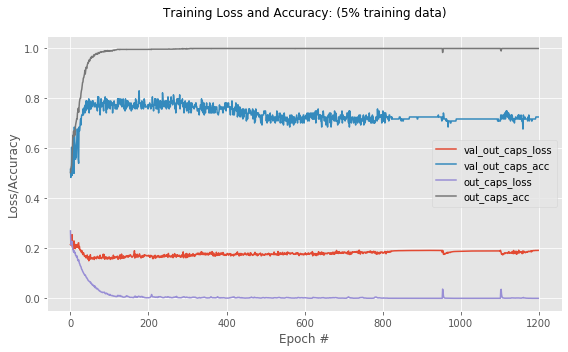


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.167    | 0.762    | 0.764     | 0.756    | 0.760   



In [33]:
for frac in [5]:
    fracTest(frac, K_SIZE, F_SIZE, D_DIM, verbose=1)

-------------------------------
Testing with filter sizes [4, 8]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


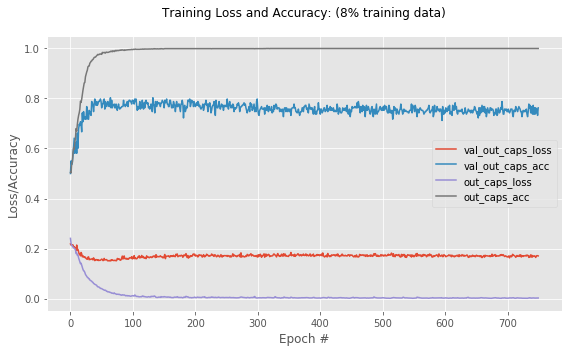


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.163    | 0.769    | 0.739     | 0.831    | 0.782   

-------------------------------
Testing with filter sizes [4, 8]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


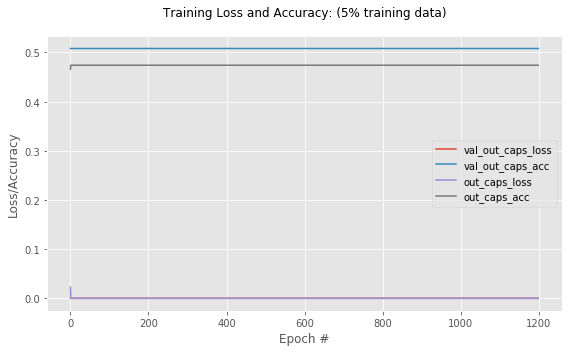


Best model (min val loss) scores


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with filter sizes [4, 8]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


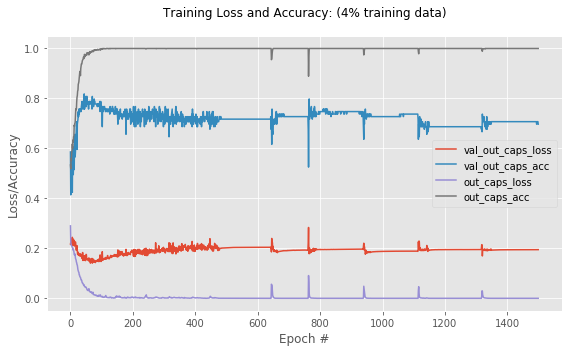


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.183    | 0.720    | 0.721     | 0.717    | 0.719   

-------------------------------
Testing with filter sizes [4, 8]
Testing with Kernel sizes [5, 11]
Testing with d_dim size 16
-------------------------------
Plotting Model accuracy and loss versus epoch


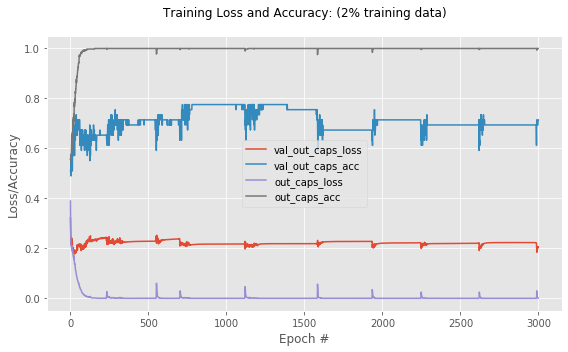


Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.210    | 0.625    | 0.609     | 0.695    | 0.649   



In [22]:
for frac in [8,5,4,2]:
    fracTest(frac, K_SIZE, F_SIZE, D_DIM)

##10. CV Test for data Fractions

In [0]:
frac=10
(f_train_X, f_train_Y, folds, f_test_X, f_test_Y) = k_fold_load_and_split(gray=False, 
                                                                          splits=10, 
                                                                          data_frac=frac/100)
print("")
cvscores = cv_test(f_train_X, f_train_Y, folds, f_test_X, f_test_Y, 
                   k=K_SIZE, 
                   d_dim=D_DIM, 
                   f_sizes=F_SIZE, 
                   nepochs=EPOCHS*100//frac)
mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
print("")
print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))

k_fold_load_and_split called for 10.0% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]
Limiting training data to 2480/275 samples

Build and train on fold number 1
Epoch 00033: early stopping
	accuracy: 94.00% model score at end of training (with fold test data)
	Model rejected. trying again
Build and train on fold number 2
Epoch 00042: early stopping
	accuracy: 98.70% model score at end of training (with fold test data)
	accuracy: 83.27% best model score on test set
Build and train on fold number 3
Epoch 0004

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 48.97% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping
	accuracy: 62.77% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00023: early stopping
	accuracy: 87.46% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00044: early stopping
	accuracy: 96.64% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 7
Epoch 00048: early stopping
	accuracy: 98.48% model score at end of training (with fold test data)
	accuracy: 81.45% best model score on test set
Build and train on fold number 8
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 48.92% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00007: early stopping
	accuracy: 70.16% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 48.92% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 48.92% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 48.92% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 48.92% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 48.92% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00040: early stopping
	accuracy: 96.86% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 9
Epoch 00040: early stopping
	accuracy: 95.97% model score at end of training (with fold test data)
	accuracy: 80.00% best model score on test set
Build and train on fold number 10
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 48.92% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00048: early stopping
	accuracy: 98.79% model score at end of training (with fold test data)
	Model rejected. trying again

Cross validation mean loss on test data 0.138 (+/- 0.007)
Cross validation mean accuracy on test data 82.24% (+/- 1.65%)
Cross validation mean precision on test data 0.775 (+/- 0.036)
Cross validation mean recall on test data 0.860 (+/- 0.029)
Cross validation mean F1 on test data 0.814 (+/- 0.012)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
frac=20
(f_train_X, f_train_Y, folds, f_test_X, f_test_Y) = k_fold_load_and_split(gray=False, 
                                                                          splits=10, 
                                                                          data_frac=frac/100)
print("")
cvscores = cv_test(f_train_X, f_train_Y, folds, f_test_X, f_test_Y, 
                   k=K_SIZE, 
                   d_dim=D_DIM, 
                   f_sizes=F_SIZE, 
                   nepochs=EPOCHS*100//frac)
mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
print("")
print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))

k_fold_load_and_split called for 20.0% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]
Limiting training data to 4960/551 samples

Build and train on fold number 1
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.07% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.07% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00042: early stopping
	accuracy: 93.08% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 2
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.07% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00028: early stopping
	accuracy: 95.99% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 3
Epoch 00031: early stopping
	accuracy: 94.71% model score at end of training (with fold test data)
	accuracy: 88.20% best model score on test set
Build and train on fold number 4
Epoch 00040: early stopping
	accuracy: 97.56% model score at end of training (with fold test data)
	accuracy: 82.40% best model score on test set
Build and train on fold number 5
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.07% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00031: early stopping
	accuracy: 92.07% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 6
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.07% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00034: early stopping
	accuracy: 96.59% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 7
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.07% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00019: early stopping
	accuracy: 92.50% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 8
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.04% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00023: early stopping
	accuracy: 91.49% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 9
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.04% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00029: early stopping
	accuracy: 95.03% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 10
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.04% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00043: early stopping
	accuracy: 97.67% model score at end of training (with fold test data)
	Model rejected. trying again

Cross validation mean loss on test data 0.113 (+/- 0.017)
Cross validation mean accuracy on test data 85.30% (+/- 2.90%)
Cross validation mean precision on test data 0.858 (+/- 0.030)
Cross validation mean recall on test data 0.869 (+/- 0.022)
Cross validation mean F1 on test data 0.864 (+/- 0.026)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
frac=40
(f_train_X, f_train_Y, folds, f_test_X, f_test_Y) = k_fold_load_and_split(gray=False, 
                                                                          splits=10, 
                                                                          data_frac=frac/100)
print("")
cvscores = cv_test(f_train_X, f_train_Y, folds, f_test_X, f_test_Y, 
                   k=K_SIZE, 
                   d_dim=D_DIM, 
                   f_sizes=F_SIZE, 
                   nepochs=EPOCHS*100//frac)
mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
print("")
print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))

k_fold_load_and_split called for 40.0% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]
Limiting training data to 9920/1102 samples

Build and train on fold number 1
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 49.98% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00023: early stopping
	accuracy: 92.19% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 2
Epoch 00026: early stopping
	accuracy: 94.97% model score at end of training (with fold test data)
	accuracy: 92.65% best model score on test set
Build and train on fold number 3
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 49.98% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00017: early stopping
	accuracy: 93.03% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 4
Epoch 00022: early stopping
	accuracy: 93.28% model score at end of training (with fold test data)
	accuracy: 92.92% best model score on test set
Build and train on fold number 5
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 49.97% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00041: early stopping
	accuracy: 98.02% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 6
Epoch 00041: early stopping
	accuracy: 96.61% model score at end of training (with fold test data)
	accuracy: 91.29% best model score on test set
Build and train on fold number 7
Epoch 00029: early stopping
	accuracy: 88.98% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 49.97% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 49.97% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 49.97% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 49.97% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 49.97% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00026: early stopping
	accuracy: 94.35% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 8
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 49.97% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00037: early stopping
	accuracy: 96.11% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 9
Epoch 00031: early stopping
	accuracy: 95.86% model score at end of training (with fold test data)
	accuracy: 92.01% best model score on test set
Build and train on fold number 10
Epoch 00036: early stopping
	accuracy: 97.20% model score at end of training (with fold test data)
	accuracy: 93.83% best model score on test set

Cross validation mean loss on test data 0.070 (+/- 0.003)
Cross validation mean accuracy on test data 92.54% (+/- 0.86%)
Cross validation mean precision on test data 0.941 (+/- 0.012)
Cross validation mean recall on test data 0.909 (+/- 0.017)
Cross validation mean F1 on test data 0.925 (+/- 0.009)


In [0]:
frac=60
(f_train_X, f_train_Y, folds, f_test_X, f_test_Y) = k_fold_load_and_split(gray=False, 
                                                                          splits=10, 
                                                                          data_frac=frac/100)
print("")
cvscores = cv_test(f_train_X, f_train_Y, folds, f_test_X, f_test_Y, 
                   k=K_SIZE, 
                   d_dim=D_DIM, 
                   f_sizes=F_SIZE, 
                   nepochs=EPOCHS*100//frac)
mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
print("")
print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))

k_fold_load_and_split called for 60.0% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]
Limiting training data to 14881/1653 samples

Build and train on fold number 1
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.07% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00028: early stopping
	accuracy: 96.01% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 2
Epoch 00030: early stopping
	accuracy: 96.40% model score at end of training (with fold test data)
	accuracy: 91.23% best model score on test set
Build and train on fold number 3
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.07% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00023: early stopping
	accuracy: 95.31% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 4
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.07% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00025: early stopping
	accuracy: 95.00% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 5
Epoch 00029: early stopping
	accuracy: 95.83% model score at end of training (with fold test data)
	accuracy: 92.68% best model score on test set
Build and train on fold number 6
Epoch 00043: early stopping
	accuracy: 95.21% model score at end of training (with fold test data)
	accuracy: 92.14% best model score on test set
Build and train on fold number 7
Epoch 00040: early stopping
	accuracy: 95.93% model score at end of training (with fold test data)
	accuracy: 92.26% best model score on test set
Build and train on fold number 8
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.07% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00020: early stopping
	accuracy: 95.96% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 9
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.07% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00022: early stopping
	accuracy: 94.36% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 10
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.07% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00025: early stopping
	accuracy: 92.67% model score at end of training (with fold test data)
	Model rejected. trying again

Cross validation mean loss on test data 0.064 (+/- 0.005)
Cross validation mean accuracy on test data 92.08% (+/- 0.53%)
Cross validation mean precision on test data 0.922 (+/- 0.015)
Cross validation mean recall on test data 0.918 (+/- 0.016)
Cross validation mean F1 on test data 0.920 (+/- 0.005)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
frac=80
(f_train_X, f_train_Y, folds, f_test_X, f_test_Y) = k_fold_load_and_split(gray=False, 
                                                                          splits=10, 
                                                                          data_frac=frac/100)
print("")
cvscores = cv_test(f_train_X, f_train_Y, folds, f_test_X, f_test_Y, 
                   k=K_SIZE, 
                   d_dim=D_DIM, 
                   f_sizes=F_SIZE, 
                   nepochs=EPOCHS*100//frac)
mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
print("")
print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))

k_fold_load_and_split called for 80.0% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]
Limiting training data to 19841/2204 samples

Build and train on fold number 1
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.33% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.33% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00024: early stopping
	accuracy: 95.13% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 2
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.33% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.33% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00025: early stopping
	accuracy: 94.30% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 3
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.33% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00036: early stopping
	accuracy: 96.02% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 4
Epoch 00032: early stopping
	accuracy: 94.65% model score at end of training (with fold test data)
	accuracy: 93.15% best model score on test set
Build and train on fold number 5
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.33% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00028: early stopping
	accuracy: 94.16% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 6
Epoch 00041: early stopping
	accuracy: 93.90% model score at end of training (with fold test data)
	accuracy: 93.38% best model score on test set
Build and train on fold number 7
Epoch 00020: early stopping
	accuracy: 94.13% model score at end of training (with fold test data)
	accuracy: 93.10% best model score on test set
Build and train on fold number 8
Epoch 00021: early stopping
	accuracy: 94.88% model score at end of training (with fold test data)
	accuracy: 93.42% best model score on test set
Build and train on fold number 9
Epoch 00002: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	accuracy: 50.33% model score at end of training (with fold test data)
	Model rejected. trying again
Epoch 00014: early stopping
	accuracy: 93.96% model score at end of training (with fold test data)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Model rejected. trying again
Build and train on fold number 10
Epoch 00044: early stopping
	accuracy: 96.04% model score at end of training (with fold test data)
	accuracy: 90.47% best model score on test set

Cross validation mean loss on test data 0.057 (+/- 0.009)
Cross validation mean accuracy on test data 92.70% (+/- 1.12%)
Cross validation mean precision on test data 0.925 (+/- 0.038)
Cross validation mean recall on test data 0.931 (+/- 0.027)
Cross validation mean F1 on test data 0.927 (+/- 0.009)


##11 Confusion Matrix and Mis-classified images
###11.1 Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

model = m100

showScores(getScores(model, test_X, test_Y))

resultsProb = model.predict([test_X, test_YC], verbose=0) 
# calculate predicted results from probabilities (horizontal axis)
results = np.argmax(resultsProb[0], axis=1) 
# Show the confusion matrix
print(confusion_matrix(test_Y, results))


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.049    | 0.940    | 0.939     | 0.942    | 0.940   
[[1293   85]
 [  80 1298]]


###11.2 Mis-classified images

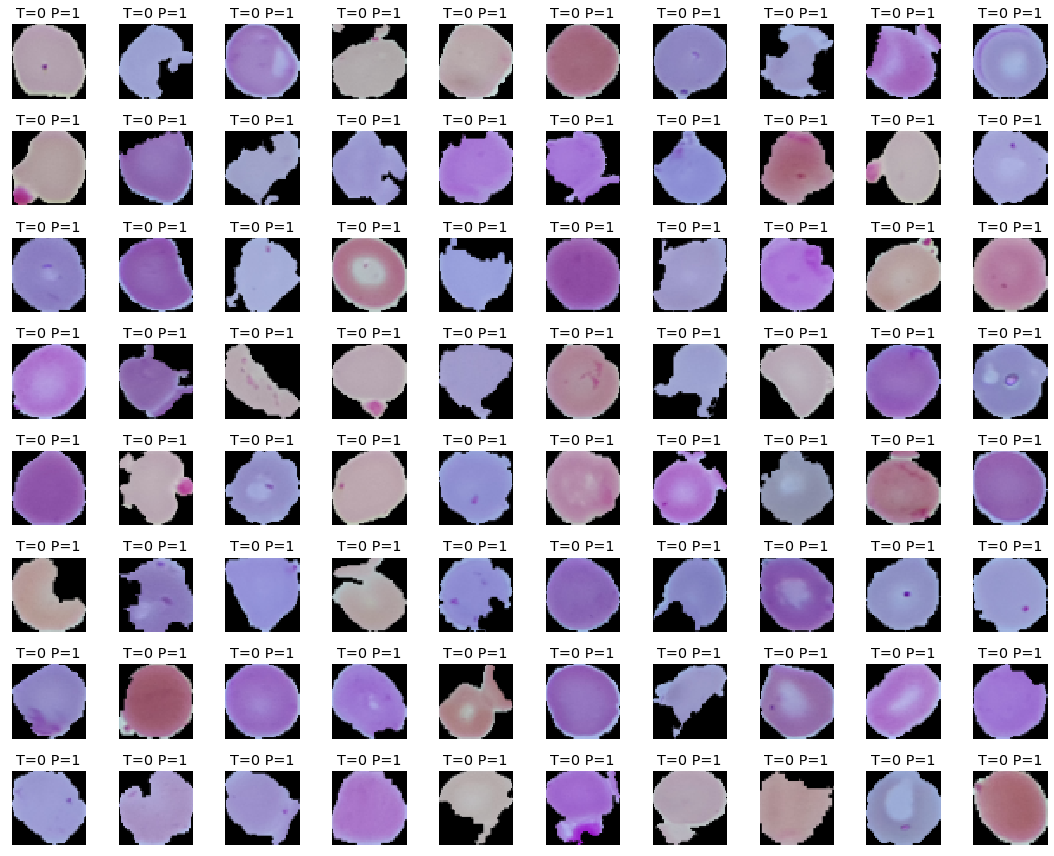

In [0]:
# Show the False Positive IMages
show_misclassified(test_Y, results, ground_truth=0, file='8_CNN_misclassified_T0P1.png')

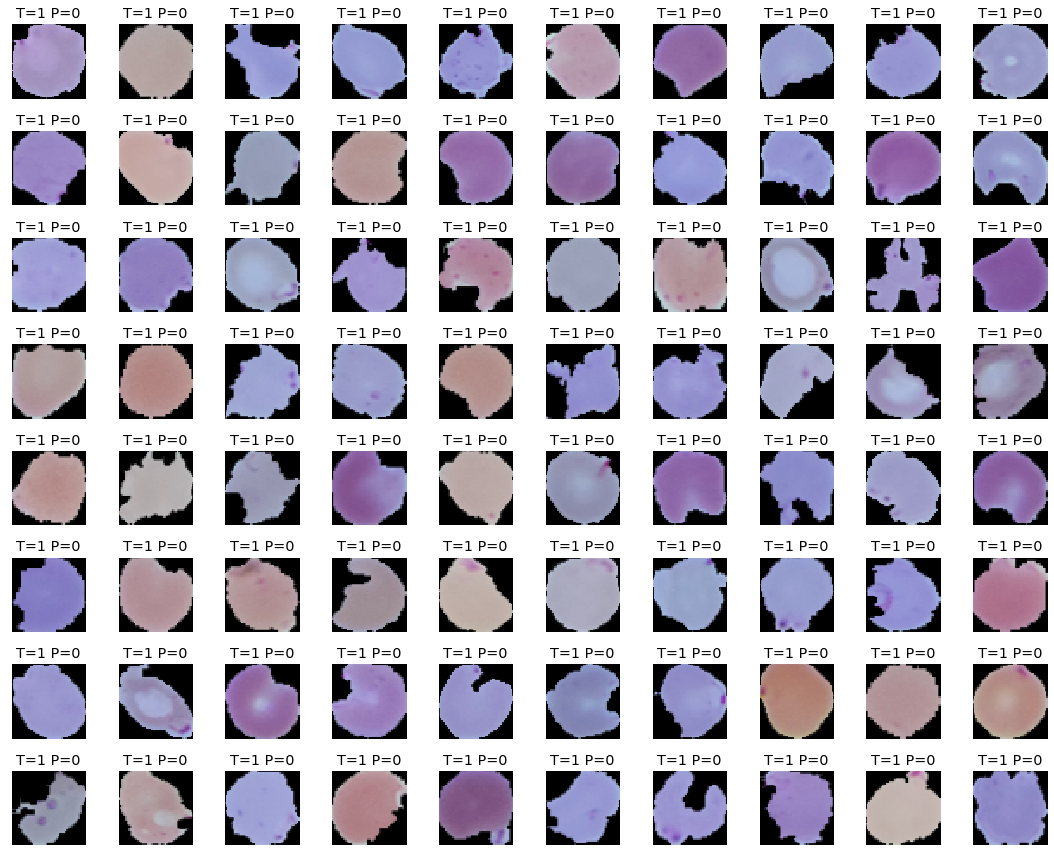

In [0]:
# Show the False Negative Images
show_misclassified(test_Y, results, ground_truth=1, file='8_CNN_misclassified_T1P0.png')

### 11.4 Visualise layers

This code is taken from from https://fairyonice.github.io/Visualization%20of%20Filters%20with%20Keras.html

In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from keras import backend as K

class VisualizeImageMaximizeFmap(object):
    def __init__(self,pic_shape, model):
        '''
        pic_shape : a dimention of a single picture e.g., (96,96,1)
        '''
        self.pic_shape = pic_shape
        self.model = model

    def find_n_feature_map(self, layer_name ,max_nfmap):
        '''
        shows the number of feature maps for this layer
        only works if the layer is CNN
        '''
        n_fmap = None
        for layer in self.model.layers:
            if layer.name == layer_name:
                weights = layer.get_weights()
                n_fmap=weights[1].shape[0]
        if n_fmap is None:
            print(layer_name + " is not one of the layer names..")
            n_fmap = 1
        n_fmap = np.min([max_nfmap,n_fmap])
        return(int(n_fmap))

    def find_image_maximizing_activation(self,
                                         iterate,
                                         input_img_data,
                                         picorig=False,
                                         n_iter = 30):
        '''
        The input image is scaled to range between 0 and 1
        picorig  : True  if the picture image for input is original scale
                         ranging between 0 and 225
                   False if the picture image for input is ranging [0,1]
        '''
            
        input_img_data = np.random.random((1, 
                                           self.pic_shape[0],
                                           self.pic_shape[1],
                                           self.pic_shape[2]))
        if picorig:
            ## if the original picture is unscaled and ranging between (0,225),
            ## then the image values are centered around 123 with STD=25
            input_img_data = input_img_data*25 + 123 


        ## I played with this step value but the final image looks to be robust
        step = 500 

        # gradient ascent
        loss_values = []
        for i in range(n_iter):
            loss_value, grads_value = iterate([input_img_data, 0])
            input_img_data += grads_value * step
            loss_values.append(loss_value) 
        return (input_img_data, loss_values)

    def create_iterate(self,input_img, layer_output, filter_index):
        '''
        layer_output[:,:,:,0] is (Nsample, 94, 94) tensor contains:
        W0^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        layer_output[:,:,:,1] contains:
        W1^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        W0 and W1 are different kernel!
        '''
        ## loss is a scalar 
        if len(layer_output.shape) == 4:
            ## conv layer 
            loss = K.mean(layer_output[:,  :, :, filter_index])
        elif len(layer_output.shape) ==2:
            ## fully connected layer
            loss = K.mean(layer_output[:, filter_index])
         
        # calculate the gradient of the loss evaluated at the provided image
        grads = K.gradients(loss, input_img)[0]
        # normalize the gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # iterate is a function taking (input_img, scalar) and output [loss_value, gradient_value]
        iterate = K.function([input_img, K.learning_phase()], [loss, grads])
        return(iterate)

    def deprocess_image(self,x):
        # standardize to have a mean 0 and std  0.1 
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x *= 0.1

        # Shift x to have a mean 0.5 and std 0.1
        # This means 95% of the x should be in between 0 and 1
        # if x is normal
        x += 0.5
        x = np.clip(x, 0, 1)

        # resclar the values to range between 0 and 255
        x *= 255
        x = np.clip(x, 0, 255).astype('uint8')

        return x

    def find_images(self,
                    input_img,
                    layer_names,
                    layer_dict, 
                    max_nfmap,
                    picorig=False,
                    n_iter=30):
        '''
        Input :

        input_img   : the alias of the input layer from the deep learning model
        layer_names : list containing the name of the layers whose feature maps to be used
        layer_dict  : symbolic outputs of each "key" layer (we gave them unique names).
        max_nfmap   : the maximum number of feature map to be used for each layer.
        pic_shape   : For example pic_shape = (96,96,1)

        Output : 
        dictionary 

        key = layer name 
        value = a list containing the tuple of (images, list of loss_values) that maximize each feature map
        '''
        argimage = {}
        ## Look for the image for each feature map of each layer one by one
        for layer_name in layer_names: ## the layer to visualize
            n_fmap = self.find_n_feature_map(layer_name,max_nfmap)
            layer_output = layer_dict[layer_name].output
            result = self.find_images_for_layer(input_img,
                                                layer_output,
                                                range(n_fmap),
                                                picorig=picorig,
                                                n_iter=n_iter)

            argimage[layer_name] = result
        return(argimage)

    def find_images_for_layer(self,
                              input_img,
                              layer_output,
                              indices,
                              picorig=False,
                              n_iter=30):
        '''
        indices : list containing index of 
                      --> filtermaps of CNN or 
                      --> nodes of fully-connected layer
        Output

        a list containing the tuple of (images, list of loss_values) 
        that maximize each feature map


        '''
        result_temp = []
        for filter_index in indices: # filtermap to visualize
                iterate = self.create_iterate(input_img, layer_output,filter_index)
                input_img_data, loss_values = self.find_image_maximizing_activation(
                    iterate,input_img,
                    picorig=picorig,
                    n_iter=n_iter)
                result_temp.append((input_img_data,loss_values))
        return(result_temp)

    def plot_images_wrapper(self,argimage,n_row = 8, scale = 1):
        '''
        scale : scale up or down the plot size
        '''
        pic_shape = self.pic_shape
        if pic_shape[2] == 1:
            pic_shape = self.pic_shape[:2]
        layer_names = argimage.keys() # np.sort(argimage.keys())

        for layer_name in layer_names:
            n_fmap = len(argimage[layer_name])
            n_col = np.ceil(n_fmap/float(n_row))
            fig = plt.figure(figsize=(n_col*scale,
                                      n_row*scale))
            fig.subplots_adjust(hspace=0.001,wspace=0.001)
            plt.title(layer_name + " n_featuremap=" + str(n_fmap))
            count = 1
            for value in argimage[layer_name]:
                input_img_data = value[0][0]
                img = self.deprocess_image(input_img_data)
                ax = fig.add_subplot(n_row,n_col,count,
                                    xticks=[],yticks=[])
                ax.imshow(img.reshape(*pic_shape),cmap="gray")
                count += 1
            plt.show()

find images that maximize feature maps
plot them...


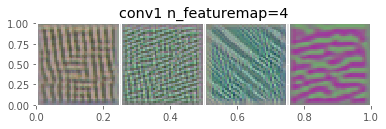

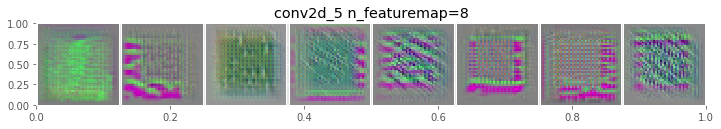

In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

input_img = model.layers[0].input
layer_names = [model.layers[1].name, model.layers[2].name]
layer_dict = dict([(layer.name, layer) for layer in model.layers])

max_nfmap = 256 #np.Inf ## print ALL the images

visualizer = VisualizeImageMaximizeFmap(pic_shape = (44,44,3), model=model)
print("find images that maximize feature maps")
argimage = visualizer.find_images(input_img,
                                  layer_names,
                                  layer_dict, 
                                  max_nfmap)
print("plot them...")
visualizer.plot_images_wrapper(argimage, n_row = 1, scale = 1.5)

### 11.5 Show Reconstruction Images. 
Note that we encode so little information that the decoder is only capable of producing a cell outline.

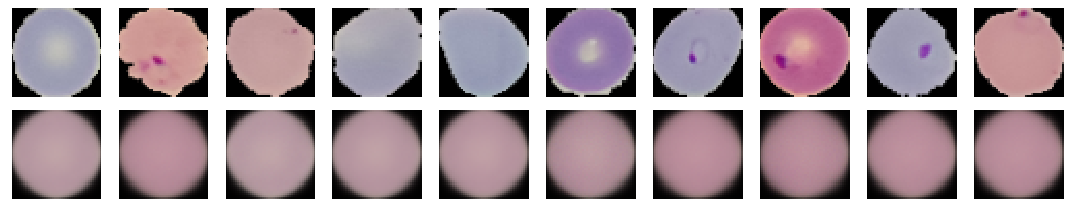

In [0]:
def genCapsReconImgs(model, data, file=None):
    x_test, y_test = data
    y_pred, x_recon = model.predict([x_test, y_test], batch_size=x_test.shape[0])
    _, W, H, C = x_test.shape
    shape = (W, H, C)
    showReconImages(x_test, x_recon, shape, n=10, file=file)

genCapsReconImgs(model=model, data=(test_X[:20], test_YC[:20]), file='8_CAPS_recon.png')

##12 Save models and images

In [34]:
%%bash
cp -f ./*.h5 "$GPATH/Models"
cp -f ./*.json "$GPATH/Models"
cp -f ./*.png "$GPATH/Images"

cp: cannot stat './*.json': No such file or directory
